Test on sample created with sample of neighbouring galaxies in uniform ditribution betwween -1 and 1 arcsecond around centered galaxy


- test of function to get the relevant parameters output of deblender

New version of deblender trained with well trained VAE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
import seaborn as sns
from tensorflow.keras import backend as K
%matplotlib inline

import tensorflow as tf

Using TensorFlow backend.


In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import vae_functions, model, utils, plot

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_deblender, load_alpha, denorm, delta_min, norm, load_vae_conv
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent, scatter_galaxies


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
from tools_for_VAE.results_processing import deblender_processing

In [4]:
import generator_deblender

In [5]:
from generator_deblender import BatchGenerator

In [6]:
from importlib import reload

In [7]:
reload(generator_deblender)

<module 'generator_deblender' from '/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Deblender/generator_deblender.py'>

In [8]:
reload(utils)

<module 'tools_for_VAE.utils' from '../../scripts/tools_for_VAE/tools_for_VAE/utils.py'>

In [9]:
from tools_for_VAE.utils import compute_deltas_for_most_blended

In [10]:
reload(plot)

<module 'tools_for_VAE.plot' from '../../scripts/tools_for_VAE/tools_for_VAE/plot.py'>

In [11]:
from generator_deblender import BatchGenerator

# Function to import dense VAE

In [12]:
# Parameters
batch_size = 100
original_dim = 64*64*6

In [12]:
alpha = K.variable(1e-4)
deblender_lsst,deblender_utils_lsst, encoder_lsst, Dkl = load_deblender('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v6/train_3/', '/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v12/bis4/', 6, folder = True)
# '/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v4/'
#K.set_value(alpha, load_alpha('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v4/'))

def deblender_loss(x, x_decoded_mean):
    xent_loss = K.mean(K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=[1,2,3]))#original_dim*
    kl_loss = K.get_value(alpha) * Dkl
    return xent_loss + K.mean(kl_loss)

deblender_lsst.compile('adam', loss=deblender_loss, metrics=['mse'])

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
alpha = K.variable(1e-2)
deblender_lsst_euclid,deblender_utils_lsst_euclid, encoder_lsst_euclid, Dkl = load_deblender('/sps/lsst/users/barcelin/weights/LSST_EUCLID/deblender/v5/train_4/mse/', '/sps/lsst/users/barcelin/weights/LSST_EUCLID/VAE/noisy/v9/bis3/mse/', 10, folder = True)
#K.set_value(alpha, load_alpha('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v4/'))

def deblender_loss(x, x_decoded_mean):
    xent_loss = K.mean(K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=[1,2,3]))#original_dim*
    kl_loss = K.get_value(alpha) * Dkl
    return xent_loss + K.mean(kl_loss)

deblender_lsst_euclid.compile('adam', loss=deblender_loss, metrics=['mse'])

## Stamp size for plots

In [14]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

# Load test list

In [15]:
r= np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/PSF_lsst_0.65/uni11/galaxies_COSMOS_test_redshift_v5.npy')

In [16]:
mag = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/PSF_lsst_0.65/uni11/galaxies_COSMOS_test_magnitude_v5.npy')

In [17]:
shift = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/PSF_lsst_0.65/uni11/galaxies_COSMOS_test_shift_v5.npy')

In [18]:
blendedness_lsst = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/PSF_lsst_0.65/uni11/galaxies_COSMOS_test_blendedness_lsst_v5.npy')

In [19]:
blendedness_total_lsst = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/PSF_lsst_0.65/uni11/galaxies_COSMOS_test_blendedness_total_lsst_v5.npy')

In [20]:
scale_radius =np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/PSF_lsst_0.65/uni11/galaxies_COSMOS_test_scale_radius_v5.npy')

In [21]:
list_of_samples = ['/sps/lsst/users/barcelin/data/blended/COSMOS/PSF_lsst_0.65/uni11/galaxies_COSMOS_test_v5.npy']#/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_2_v4.npy

In [22]:
list_of_shifts = ['/sps/lsst/users/barcelin/data/blended/COSMOS/PSF_lsst_0.65/uni11/galaxies_COSMOS_test_shift_v5.npy']

In [23]:
SNR_peak_old = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/PSF_lsst_0.65/uni11/galaxies_COSMOS_test_SNR_peak_old_v5.npy')

In [24]:
SNR_peak = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/PSF_lsst_0.65/uni11/galaxies_COSMOS_test_SNR_peak_v5.npy')

In [25]:
SNR = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/PSF_lsst_0.65/uni11/galaxies_COSMOS_test_SNR_v5.npy')

median of input SNR for LSST R filter deblender: 43.2782228277536
mean of input SNR for LSST R filter deblender: 109.028316235382
min of input SNR for LSST R filter deblender: 6.239319790796819


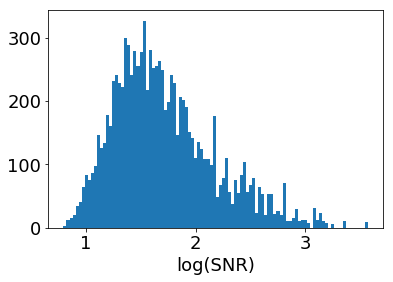

In [64]:
_ = plt.hist(np.log10(SNR), bins = 100)
plt.xlabel('log(SNR)')
print('median of input SNR for LSST R filter deblender: '+str(np.median(SNR[:])))
print('mean of input SNR for LSST R filter deblender: '+str(np.mean(SNR[:])))
print('min of input SNR for LSST R filter deblender: '+str(np.min(SNR[:])))

median of input SNR for LSST R filter VAE: 11.950355565006483
mean of input SNR for LSST R filter VAE: 30.261075224612263


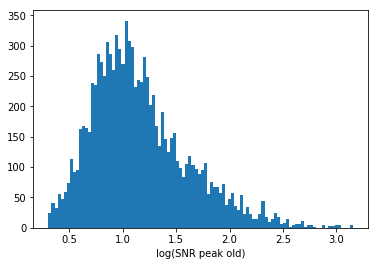

In [34]:
_ = plt.hist(np.log10(SNR_peak_old), bins = 100)
plt.xlabel('log(SNR peak old)')
print('median of input SNR for LSST R filter VAE: '+str(np.median(SNR_peak_old)))
print('mean of input SNR for LSST R filter VAE: '+str(np.mean(SNR_peak_old)))

# Batch Generation

In [26]:
bands_lsst = [4,5,6,7,8,9]

In [27]:
batch_gen = BatchGenerator(bands_lsst, list_of_samples,total_sample_size=10000, batch_size= 100, magnitude = mag, shift = shift, blendedness = blendedness_lsst, blendedness_total = blendedness_total_lsst, scale_radius = np.array(scale_radius), SNR = SNR, trainval_or_test = 'test', noisy = True)#_lsst_process

In [28]:
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

In [29]:
batch_gen_lsst_euclid = BatchGenerator(bands_lsst_euclid, list_of_samples,total_sample_size=10000, batch_size= 100, magnitude = mag, shift = shift, blendedness = blendedness_lsst, blendedness_total = blendedness_total_lsst, scale_radius = np.array(scale_radius), SNR = SNR, trainval_or_test = 'test', noisy = True)#_lsst_process

## LSST only

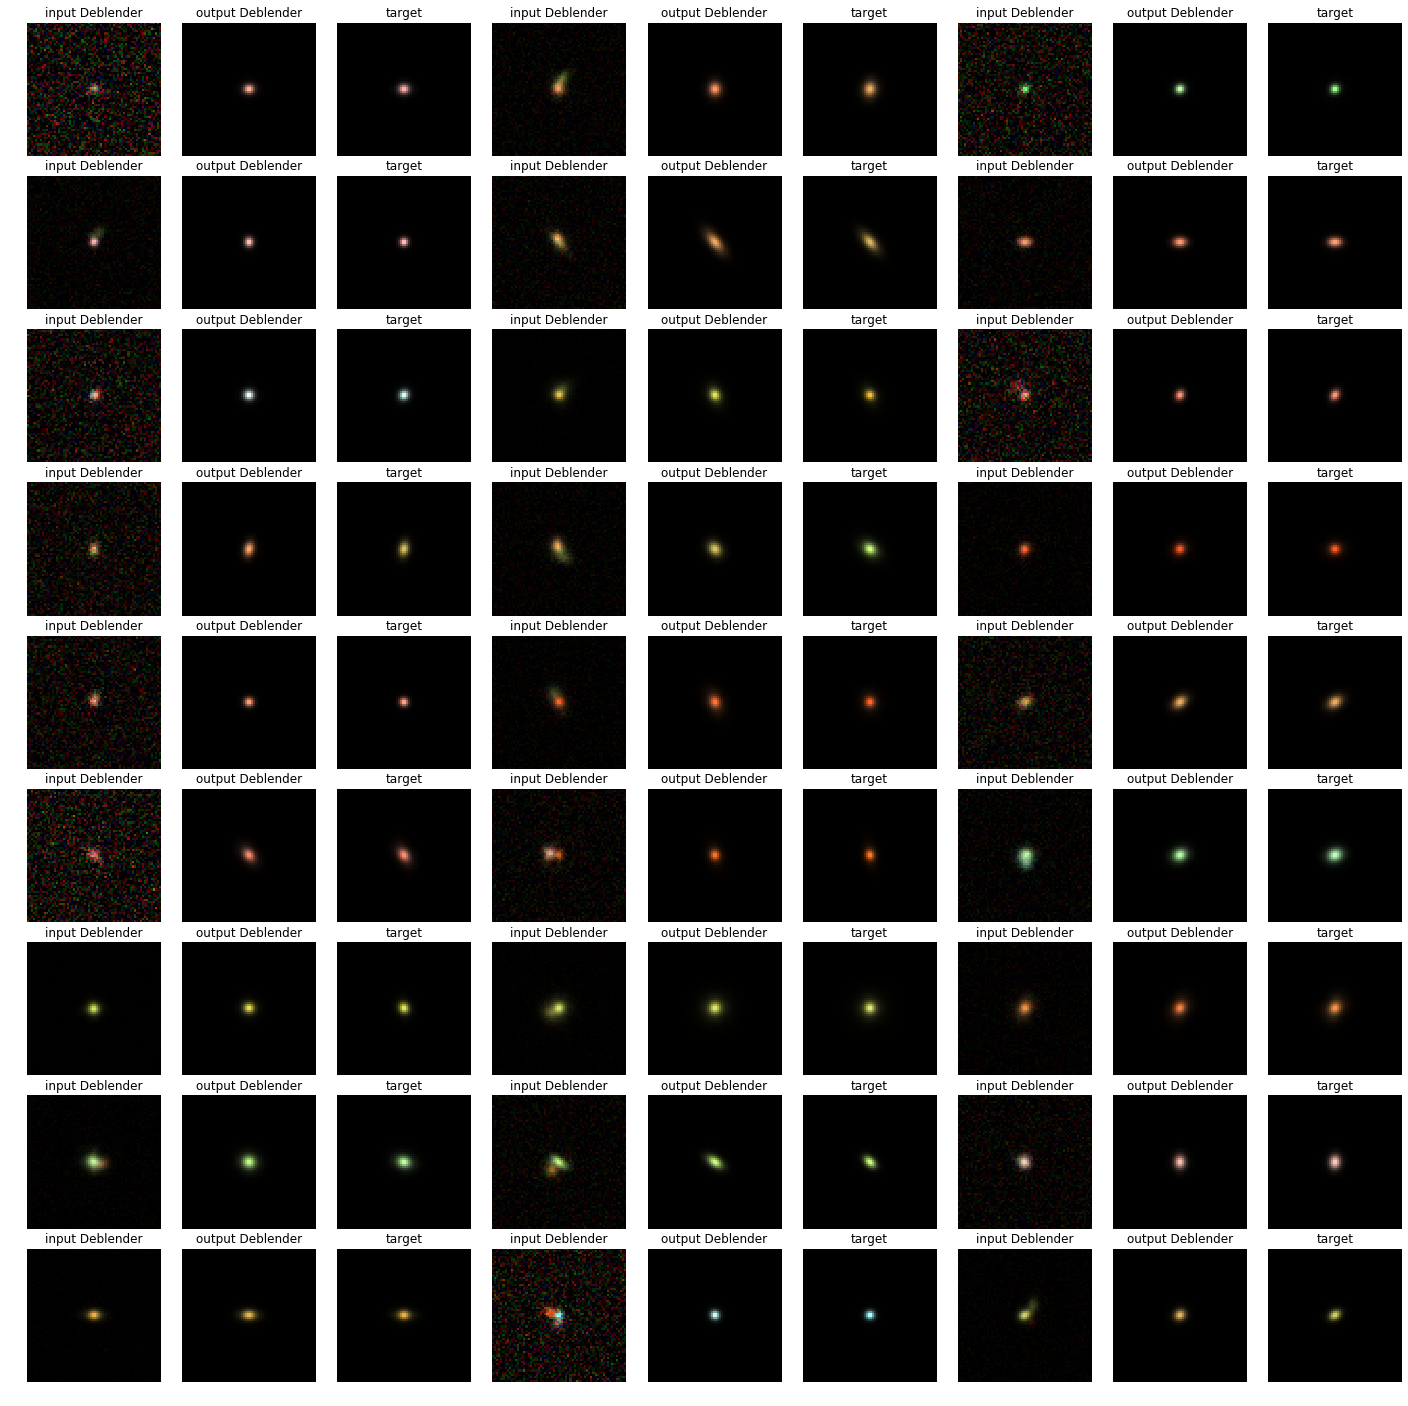

In [31]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
input_noisy = input_lsst[0]
input_noiseless = input_lsst[1]

output_deblender_lsst = deblender_lsst.predict(input_lsst[0], batch_size = 100)

output_deblender_lsst = denorm(output_deblender_lsst, bands_lsst, channel_last = True)
input_noisy = denorm(input_noisy, bands_lsst, channel_last = True)
input_noiseless = denorm(input_noiseless, bands_lsst, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst(input_noisy[indices[i*N_plot+j]],stamp_size, axes[i,j])#input_vae
        plot_rgb_lsst(output_deblender_lsst[indices[i*N_plot+j]],stamp_size, axes[i,j+1])#output_vae
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]],stamp_size, axes[i,j+2])#output_vae

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

In [110]:
N_plot = 3

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
input_noisy = input_lsst[0]
input_noiseless = input_lsst[1]

output_deblender_lsst = deblender.predict(input_lsst[0], batch_size = 100)

output_deblender_lsst = denorm(output_deblender_lsst, bands_lsst, channel_last = True)
input_noisy = denorm(input_noisy, bands_lsst, channel_last = True)
input_noiseless = denorm(input_noiseless, bands_lsst, channel_last = True)

mag = input_lsst[2]
shift = input_lsst[3]
blendedness_lsst = input_lsst[7]

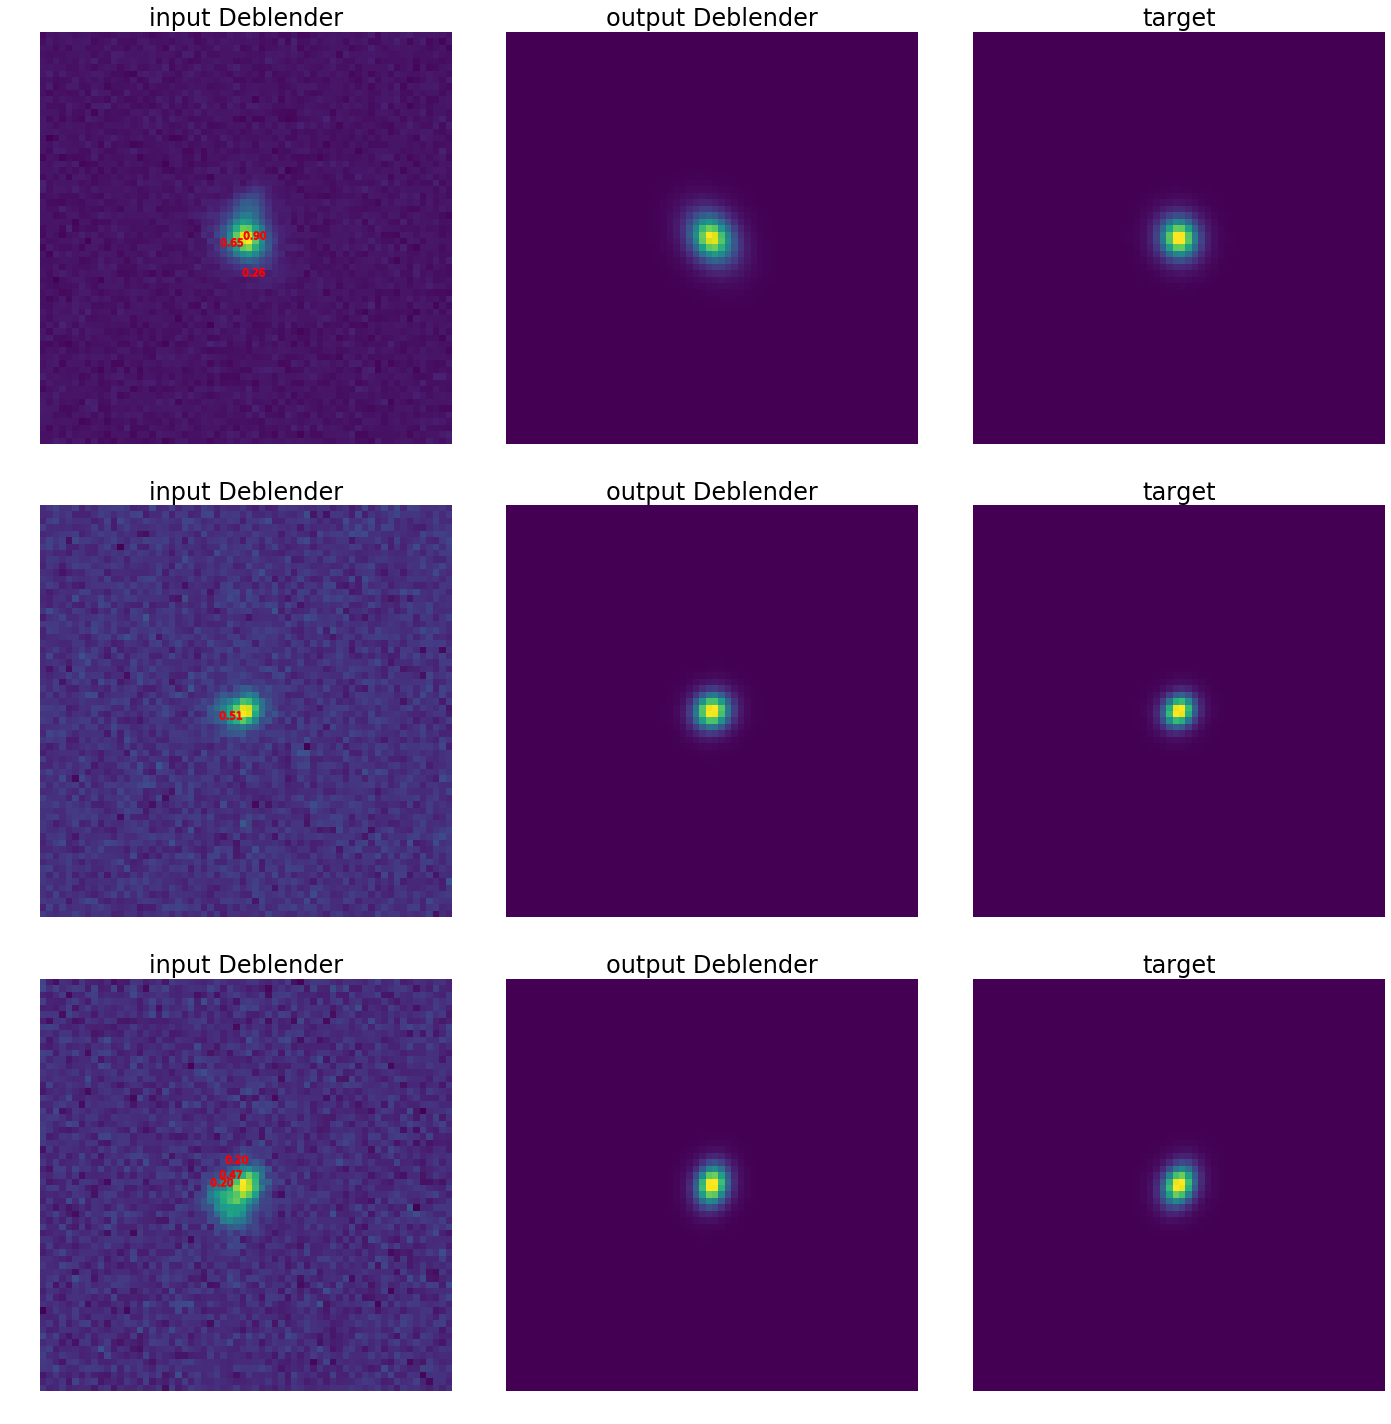

In [111]:
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        scatter_galaxies(input_noisy[indices[i*N_plot+j]][:,:,2], shift[indices[i*N_plot+j]],0.2,64,scatter = 'blendedness', blendedness = blendedness_lsst[indices[i*N_plot+j]], ax = axes[i,j])

        axes[i,j+1].imshow(output_deblender_lsst[indices[i*N_plot+j]][:,:,2])
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]][:,:,2])
        
        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

In [112]:
N_plot = 9

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
input_noisy = input_lsst[0]
input_noiseless = input_lsst[1]

output_deblender_lsst = deblender.predict(input_lsst[0], batch_size = 100)

output_deblender_lsst = denorm(output_deblender_lsst, bands_lsst, channel_last = True)
input_noisy = denorm(input_noisy, bands_lsst, channel_last = True)
input_noiseless = denorm(input_noiseless, bands_lsst, channel_last = True)

mag = input_lsst[2]
shift = input_lsst[3]
blendedness_lsst = input_lsst[7]

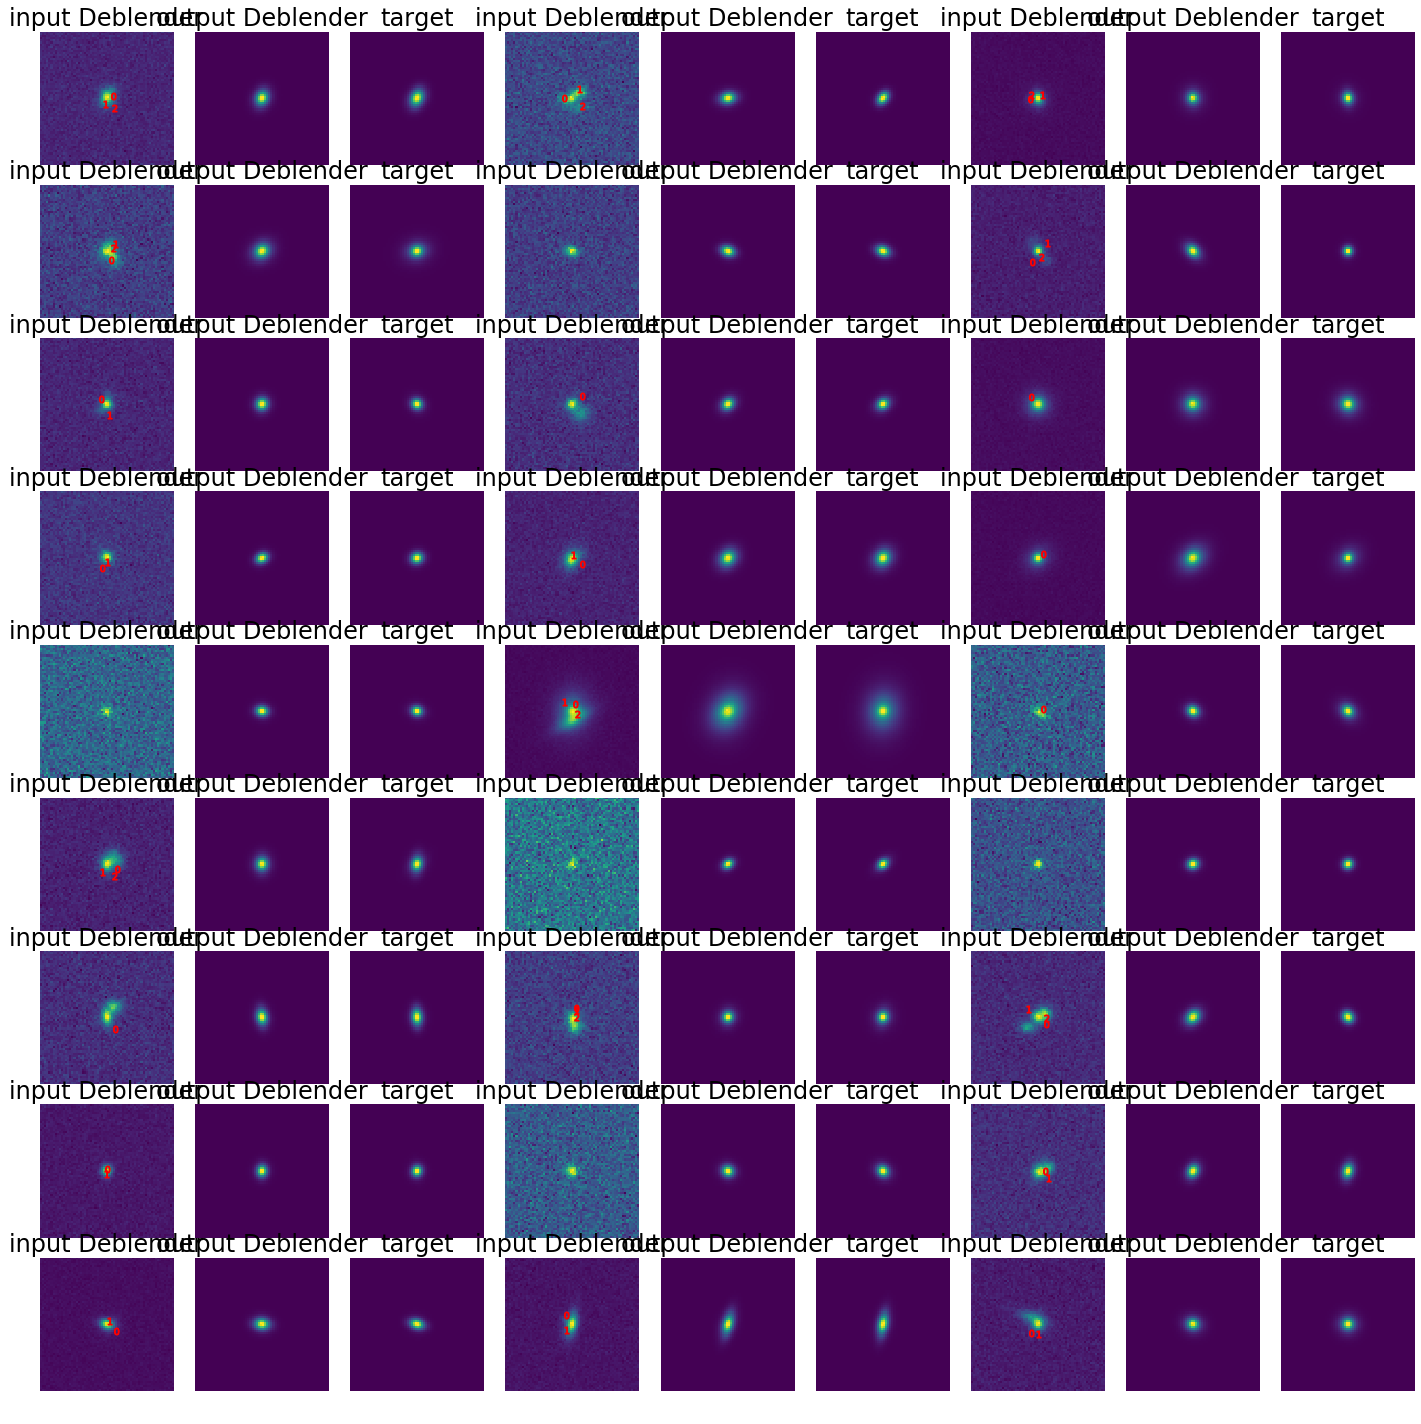

In [113]:
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        scatter_galaxies(input_noisy[indices[i*N_plot+j]][:,:,2], shift[indices[i*N_plot+j]],0.2,64, ax = axes[i,j])

        axes[i,j+1].imshow(output_deblender_lsst[indices[i*N_plot+j]][:,:,2])
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]][:,:,2])
        
        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

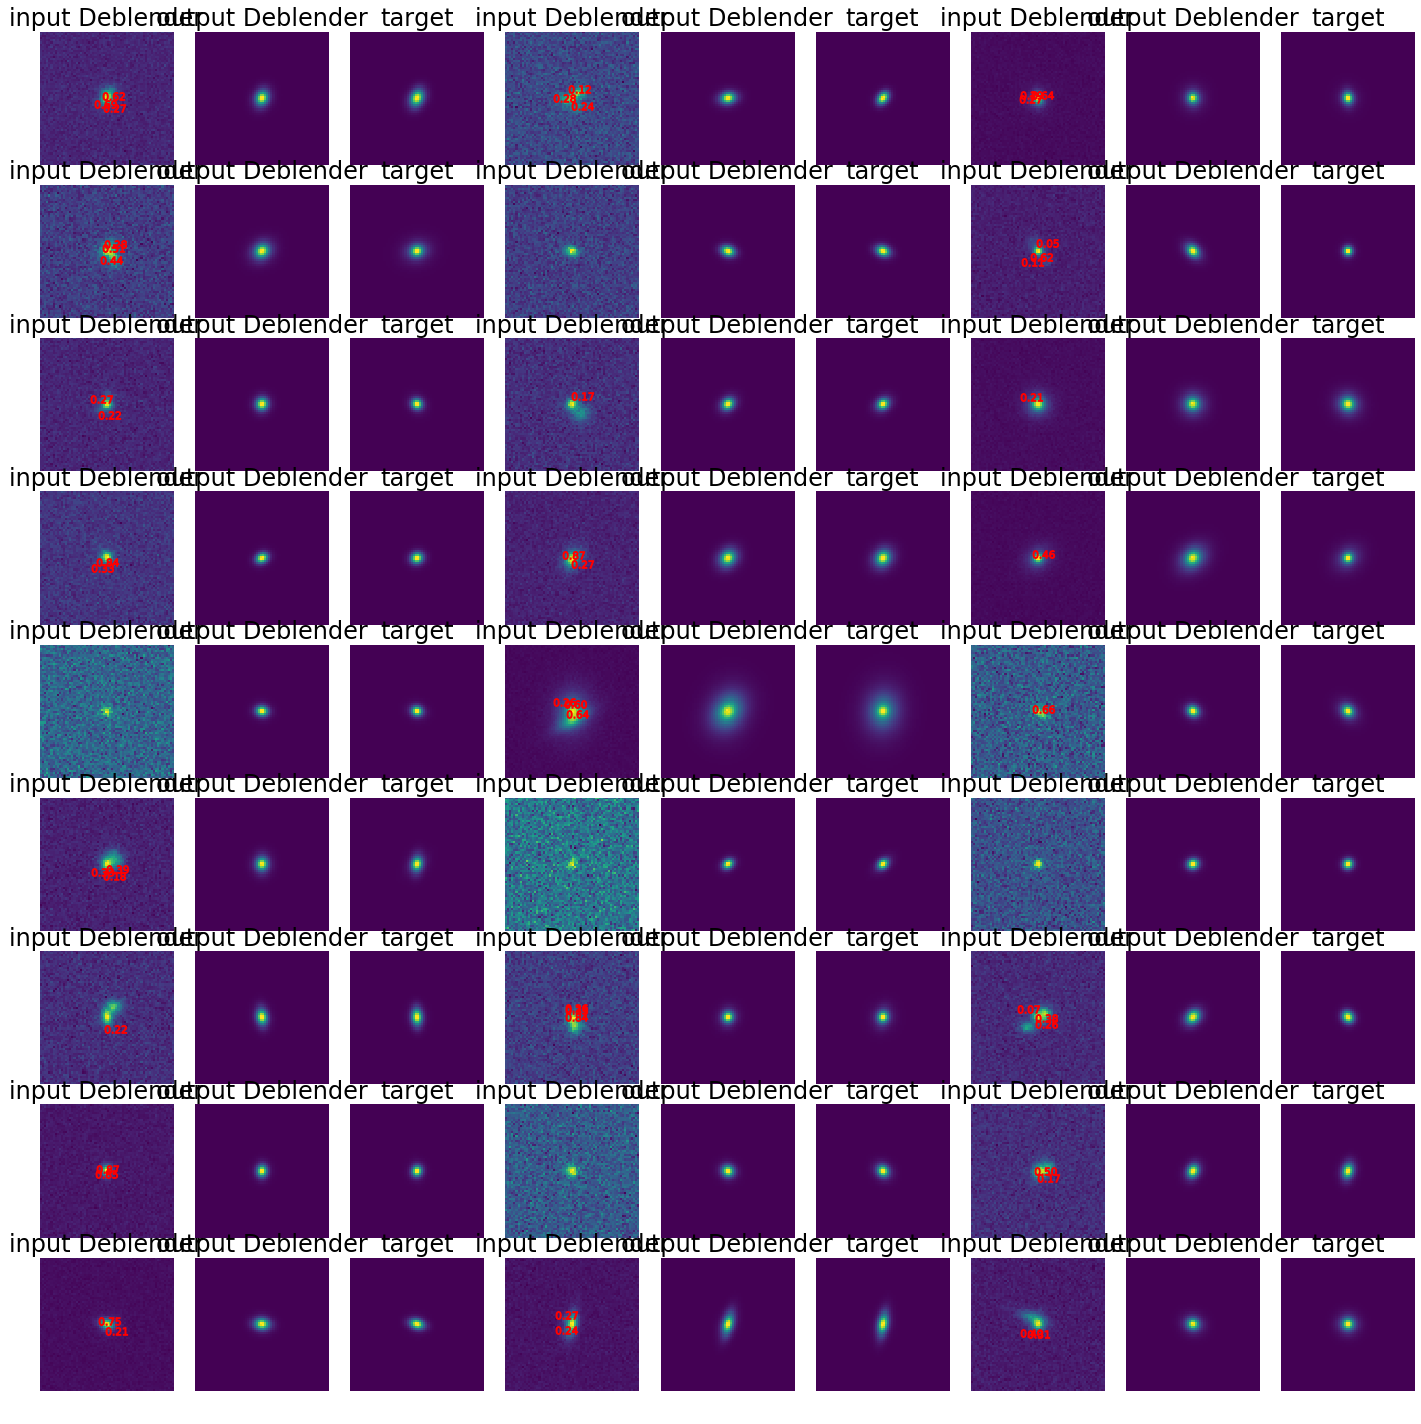

In [114]:
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        scatter_galaxies(input_noisy[indices[i*N_plot+j]][:,:,2], shift[indices[i*N_plot+j]],0.2,64,scatter = 'blendedness', blendedness = blendedness_lsst[indices[i*N_plot+j]], ax = axes[i,j])

        axes[i,j+1].imshow(output_deblender_lsst[indices[i*N_plot+j]][:,:,2])
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]][:,:,2])
        
        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

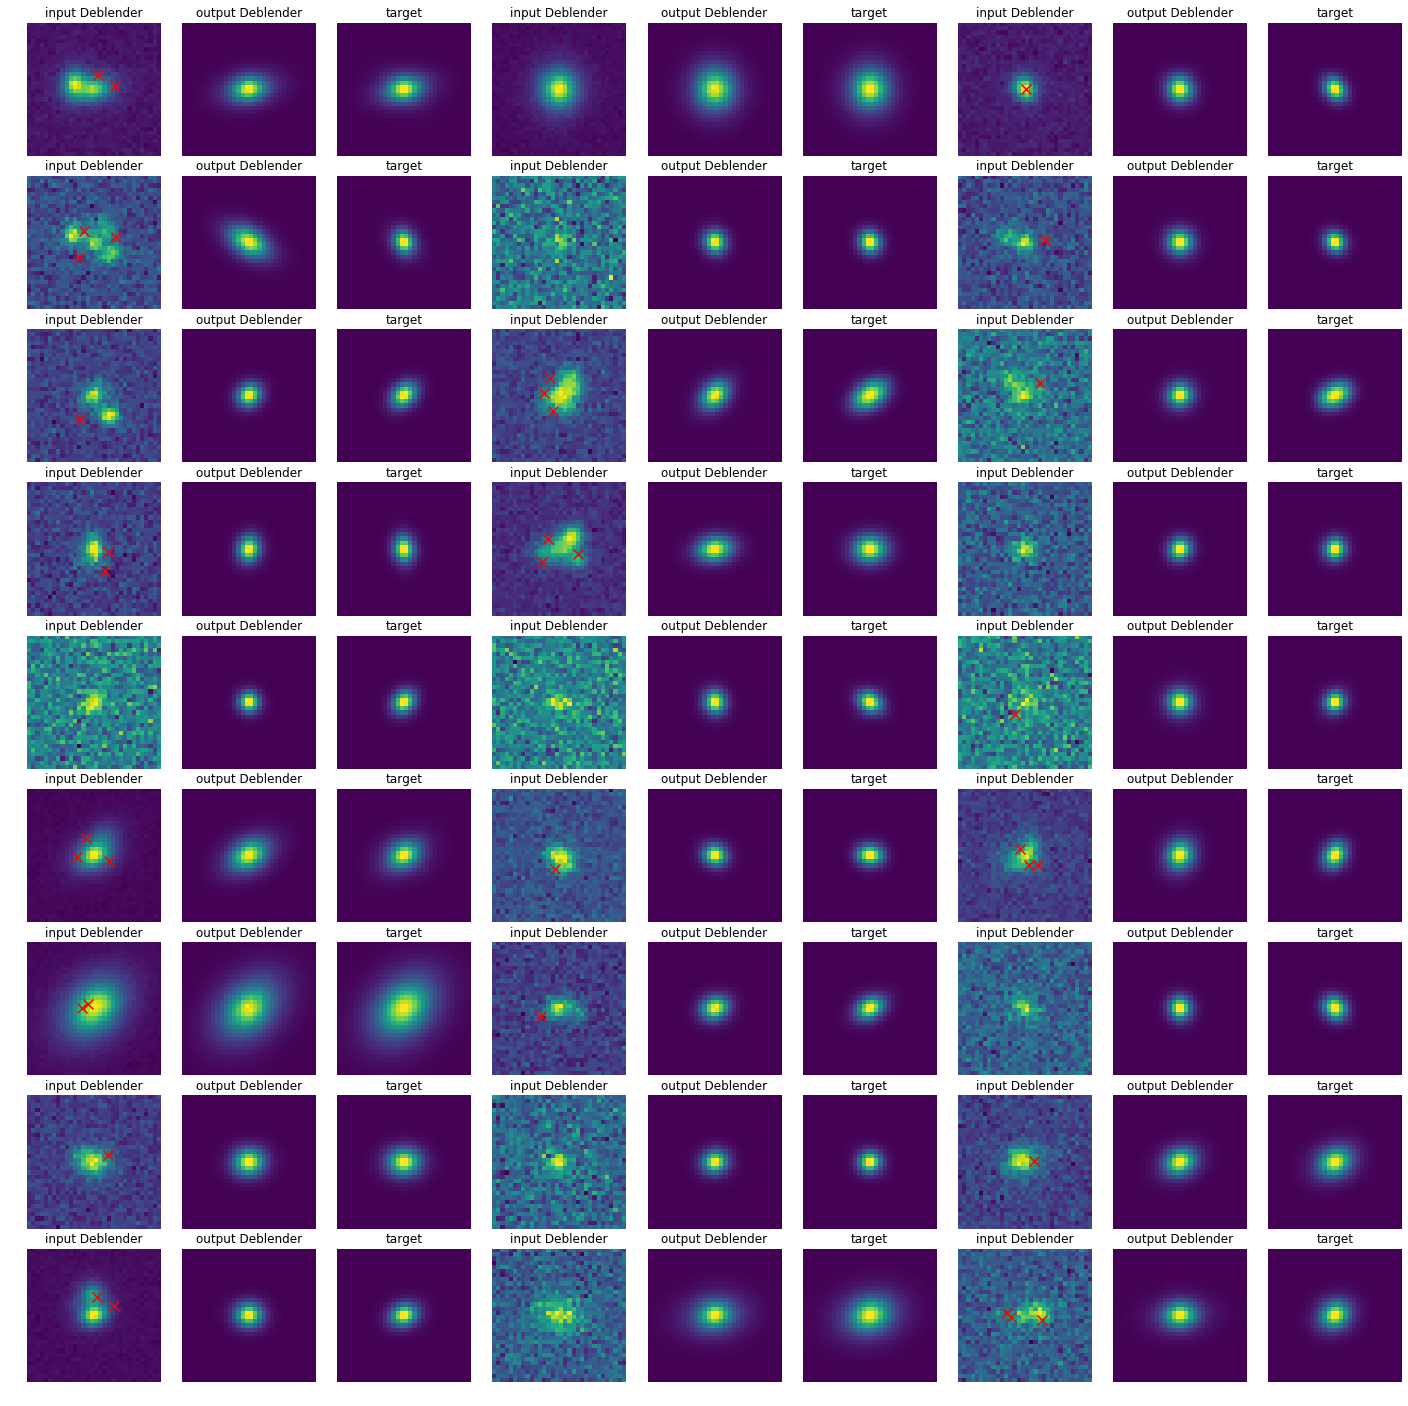

In [38]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
input_noisy = input_lsst[0]
input_noiseless = input_lsst[1]

output_deblender_lsst = deblender.predict(input_lsst[0], batch_size = 100)

output_deblender_lsst = denorm(output_deblender_lsst, bands_lsst, channel_last = True)
input_noisy = denorm(input_noisy, bands_lsst, channel_last = True)
input_noiseless = denorm(input_noiseless, bands_lsst, channel_last = True)

mag = input_lsst[2]
shift = input_lsst[3]

for i in range(N_plot):
    for j in range(0,N_plot,3):
        axes[i,j].imshow(input_noisy[indices[i*N_plot+j]][16:48,16:48,2])
        
        for k in range (len(shift[indices[i*N_plot+j]])):
            axes[i,j].scatter(16+shift[indices[i*N_plot+j]][k][0]/0.2, 16+shift[indices[i*N_plot+j]][k][1]/0.2,s = 100,c='red', marker='x')

        axes[i,j+1].imshow(output_deblender_lsst[indices[i*N_plot+j]][16:48,16:48,2])
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]][16:48,16:48,2])
        
        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')
        
        

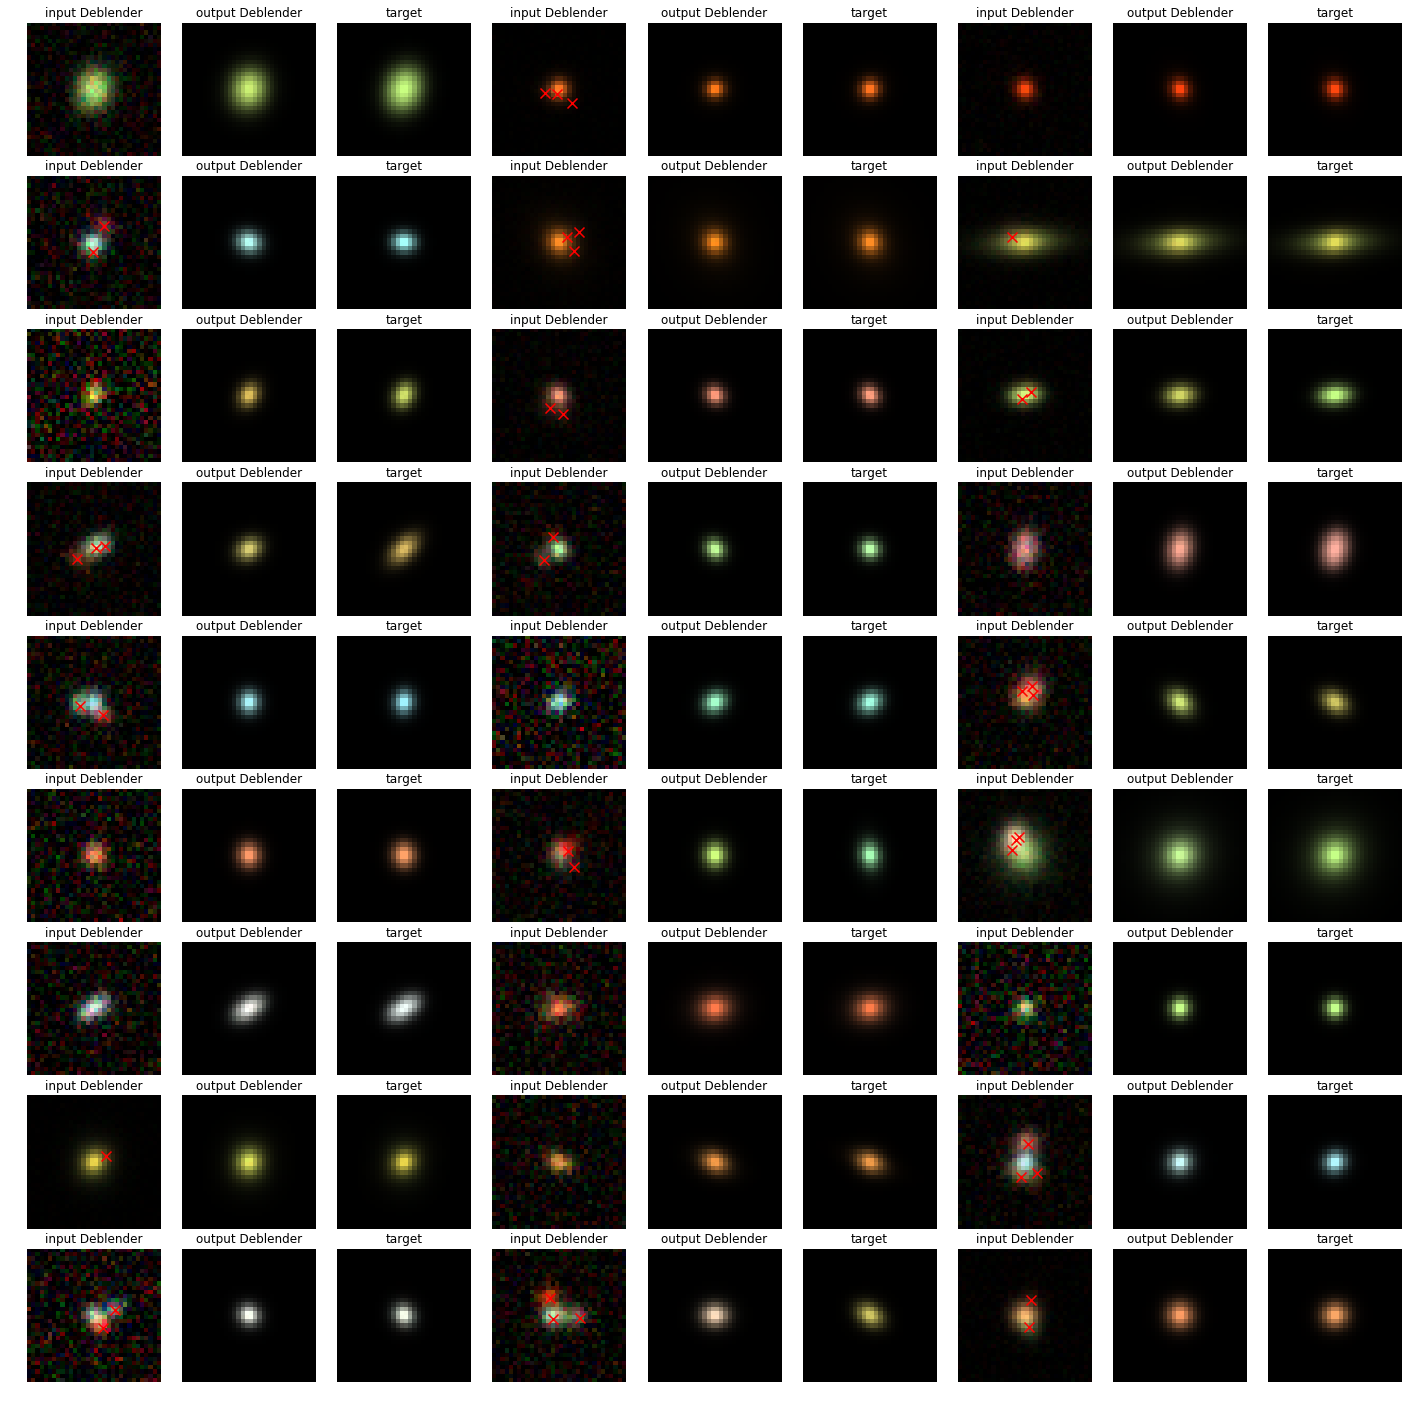

In [33]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
input_noisy = input_lsst[0]
input_noiseless = input_lsst[1]
shift = input_lsst[3]

output_deblender_lsst = deblender_lsst.predict(input_lsst[0], batch_size = 100)

output_deblender_lsst = denorm(output_deblender_lsst, bands_lsst, channel_last = True)
input_noisy = denorm(input_noisy, bands_lsst, channel_last = True)
input_noiseless = denorm(input_noiseless, bands_lsst, channel_last = True)


for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst(input_noisy[indices[i*N_plot+j]][16:48,16:48],int(stamp_size/2), axes[i,j])#input_vae
        for k in range (len(shift[indices[i*N_plot+j]])):
            axes[i,j].scatter(16+shift[indices[i*N_plot+j]][k][0]/0.2, 16+shift[indices[i*N_plot+j]][k][1]/0.2,s = 100,c='red', marker='x')

        plot_rgb_lsst(output_deblender_lsst[indices[i*N_plot+j]][16:48,16:48],int(stamp_size/2), axes[i,j+1])#output_vae
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]][16:48,16:48],int(stamp_size/2), axes[i,j+2])#output_vae

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

# Shape reproduction

In [35]:
N = 100
batch_size = 100

ellipticities_lsst,e_beta_lsst, flux_in_lsst, flux_out_lsst, magnitudes_lsst, delta_r_lsst, delta_mag_lsst, max_blendedness_lsst, blend_total_lsst, SNR_lsst = deblender_processing(deblender_lsst, batch_gen,bands_lsst,2,stamp_size, N, batch_size)

In [ ]:
magnitudes_lsst.shape

In [ ]:
#np.save('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_ellipticities_deb_lsst.npy', [ellipticities_lsst,e_beta_lsst])
#np.save('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_magnitudes_deb_lsst.npy', magnitudes_lsst)
#np.save('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_rest_deb_lsst.npy', [flux_in_lsst, flux_out_lsst, delta_r_lsst, delta_mag_lsst, max_blendedness_lsst, blend_total_lsst, SNR_lsst])

In [ ]:
#ellipticities_lsst,e_beta_lsst = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_ellipticities_deb_lsst.npy')
#magnitudes_lsst = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_magnitudes_deb_lsst.npy')
#flux_in_lsst, flux_out_lsst, delta_r_lsst, delta_mag_lsst, max_blendedness_lsst, blend_total_lsst, SNR_lsst = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_rest_deb_lsst.npy')


In [36]:
delta_e1_lsst = ellipticities_lsst[:,1,0] - ellipticities_lsst[:,0,0]
delta_e2_lsst = ellipticities_lsst[:,1,1] - ellipticities_lsst[:,0,1]
delta_e_lsst =  e_beta_lsst[:,1,0] - e_beta_lsst[:,0,0]

Plots

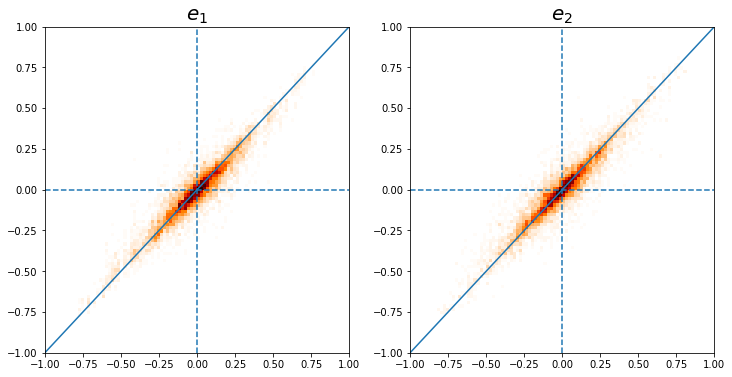

In [37]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_lsst[:,0,i], ellipticities_lsst[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    

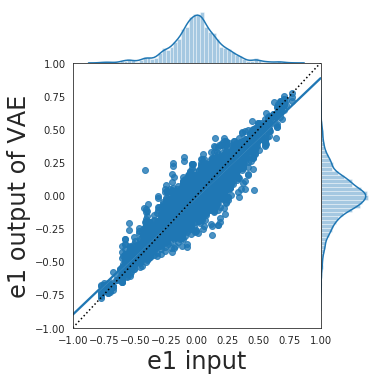

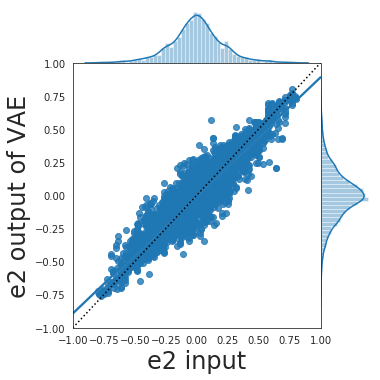

In [38]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_lsst[:,0,0], ellipticities_lsst[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_lsst[:,0,1], ellipticities_lsst[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

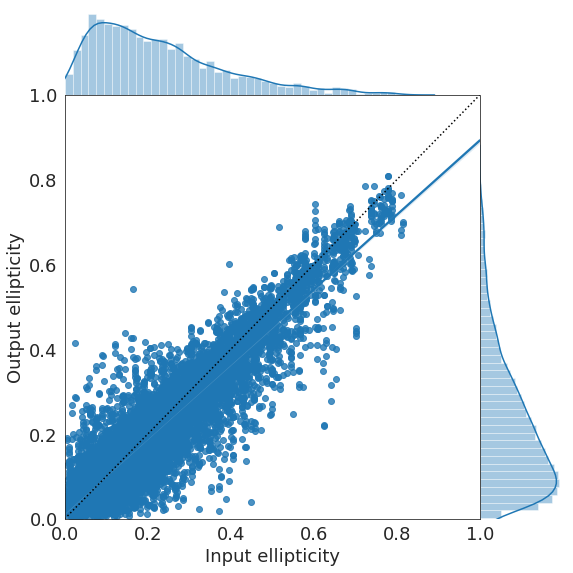

In [39]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
    
            g = sns.jointplot(e_beta_lsst[:,0,0], e_beta_lsst[:,1,0], kind='reg',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')

In [40]:
# Linear regression
slope_lsst, intercept_lsst, r_value_lsst, p_value_lsst, std_err_lsst = stats.linregress(e_beta_lsst[:,0,0], e_beta_lsst[:,1,0])

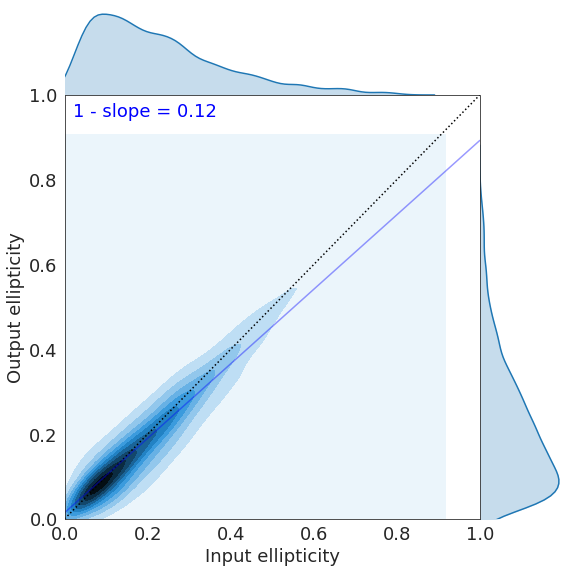

In [41]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
    
            g = sns.jointplot(e_beta_lsst[:,0,0], e_beta_lsst[:,1,0], kind='kde',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')
            g.ax_joint.plot(np.linspace(0, 1),
                            slope_lsst*np.linspace(0, 1)+intercept_lsst, color = 'b', alpha = 0.4)
            g.ax_joint.text(0.02, 0.95, '1 - slope = '+str(round(1-slope_lsst, 2)), color='b')

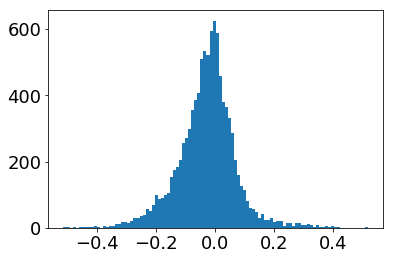

In [92]:
_ = plt.hist(delta_e_lsst, bins = 100)

###### Luminosity

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


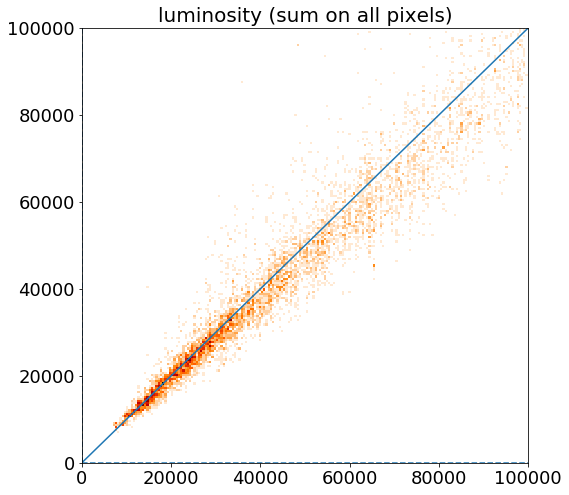

In [42]:
import matplotlib as mpl

max_lum = np.max(flux_in_lsst)

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(flux_in_lsst, flux_out_lsst, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

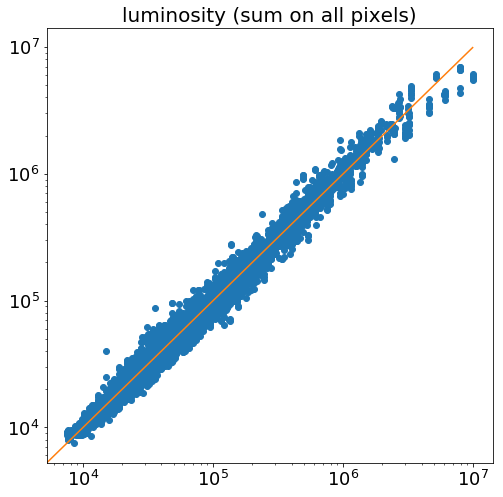

In [43]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = np.max(flux_in_lsst)
axes.plot(flux_in_lsst, flux_out_lsst,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
#axes.set_xlim(0,emax)
#axes.set_ylim(0,emax)
axes.set_xscale('log')
axes.set_yscale('log')

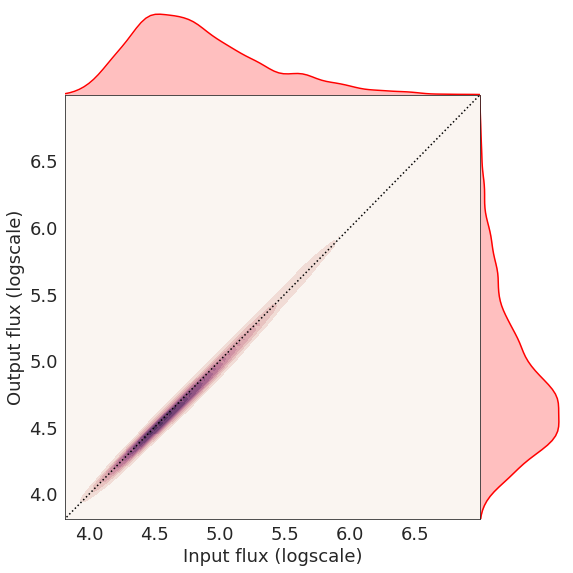

In [44]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
with sns.axes_style('white'):
            g = sns.jointplot(np.log10(flux_in_lsst), np.log10(flux_out_lsst), kind='kde',height =8,
                              xlim =[np.min(np.log10(flux_in_lsst-1000)), np.max(np.log10(flux_in_lsst))], ylim=[np.min(np.log10(flux_in_lsst-1000)), np.max(np.log10(flux_in_lsst))],cmap=cmap,color = 'red', space=0).set_axis_labels('Input flux (logscale)', 'Output flux (logscale)')
            #g.ax_joint.set_xscale('log')#color = sns.xkcd_rgb["dark green"],
            #g.ax_joint.set_yscale('log')
            g.ax_joint.plot(np.linspace(-1, np.max(np.log10(flux_in_lsst))),
                            np.linspace(-1, np.max(np.log10(flux_in_lsst))), ':k')

Flux in all bands

In [45]:
N = 100

generator = batch_gen
deblender = deblender_lsst
bands = bands_lsst
im_size = stamp_size
batch_size = 100

flux_in_all_bands_lsst = np.empty([N,batch_size,6],dtype='float32')
flux_out_all_bands_lsst= np.empty([N,batch_size,6], dtype='float32')
for j in range(N):
    input_vae = generator.__getitem__(2)
    output_vae = deblender.predict(input_vae[0], batch_size = batch_size)
    output_vae = utils.denorm(output_vae, bands, channel_last = True)
    input_noiseless = utils.denorm(input_vae[1], bands, channel_last = True)

    for i in range (len(input_vae[0])):
        for k in range (len(input_noiseless[i][0,0])):
            # Measurement of fluxes
            mask = plot.createCircularMask(im_size,im_size,None,5)
            masked_img_in_simple = input_noiseless[i][:,:,k].copy()
            masked_img_in_simple[~mask] = 0  

            masked_img_out_simple = output_vae[i][:,:,k].copy()
            masked_img_out_simple[~mask] = 0

            # Calculate the luminosity by substracting the noise
            flux_in_all_bands_lsst[j,i,k] = np.sum(masked_img_in_simple)
            flux_out_all_bands_lsst[j,i,k] = np.sum(masked_img_out_simple)


In [46]:
flux_in_all_bands_lsst = np.concatenate(flux_in_all_bands_lsst, axis =0)
flux_out_all_bands_lsst = np.concatenate(flux_out_all_bands_lsst, axis =0)

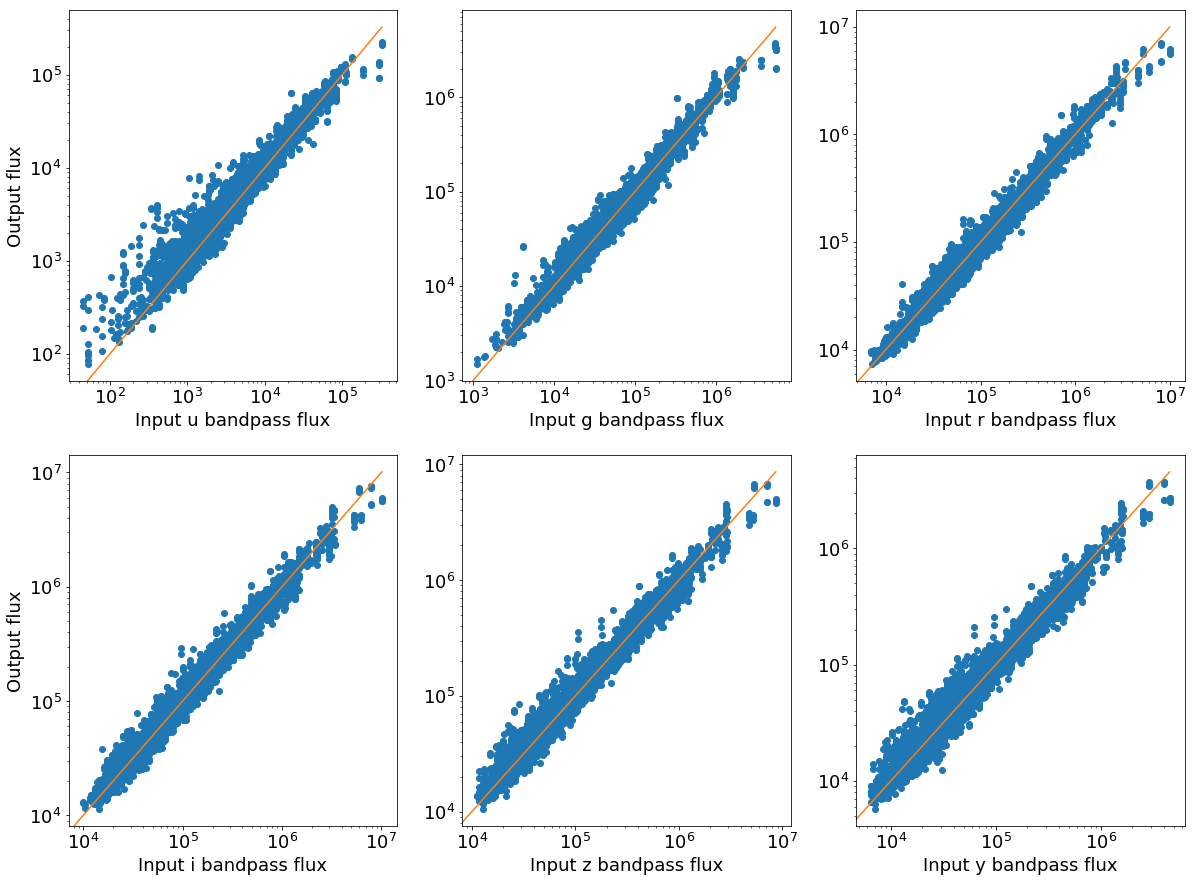

In [47]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

import matplotlib as mpl

N = 3
fig, axes = plt.subplots(2,N, figsize=(20,15))

filter_names_all = 'ugrizy'

j = 0
i = 0

for filter_name in filter_names_all:
    ax = axes[j,i]
    ax.plot(flux_in_all_bands_lsst[:,i+j*N], flux_out_all_bands_lsst[:,i+j*N],'o')
    emax = np.max(flux_in_all_bands_lsst[:,i+j*N])
    ax.plot([-emax,+emax],[-emax,+emax])
    ax.spines['bottom']
    ax.spines['right']
    ax.spines['left']
    ax.spines['top']
    ax.xaxis.label
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    if i == 0 or i == 3:
        ax.set_ylabel('Output flux')
    ax.set_xlabel('Input {0} bandpass flux'.format(filter_name))
    ax.set_xscale('log')
    ax.set_yscale('log')
    if i == 2:
        j = 1
        i = 0
    else:
        i+=1

###### Corner plot for latent space

In [51]:
batch_size = 100

In [52]:
a = batch_gen.__getitem__(2)
output_enc = encoder.predict(a[0], batch_size = batch_size)

In [53]:
latent_dim =32
epsilon_std = 1.0

In [54]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon


z = []
for i in range (100):
    a = batch_gen.__getitem__(2)
    output_enc = encoder.predict(a[0], batch_size = batch_size)
    z.append(sampling(output_enc))

In [55]:
z = np.concatenate(z, axis = 0)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


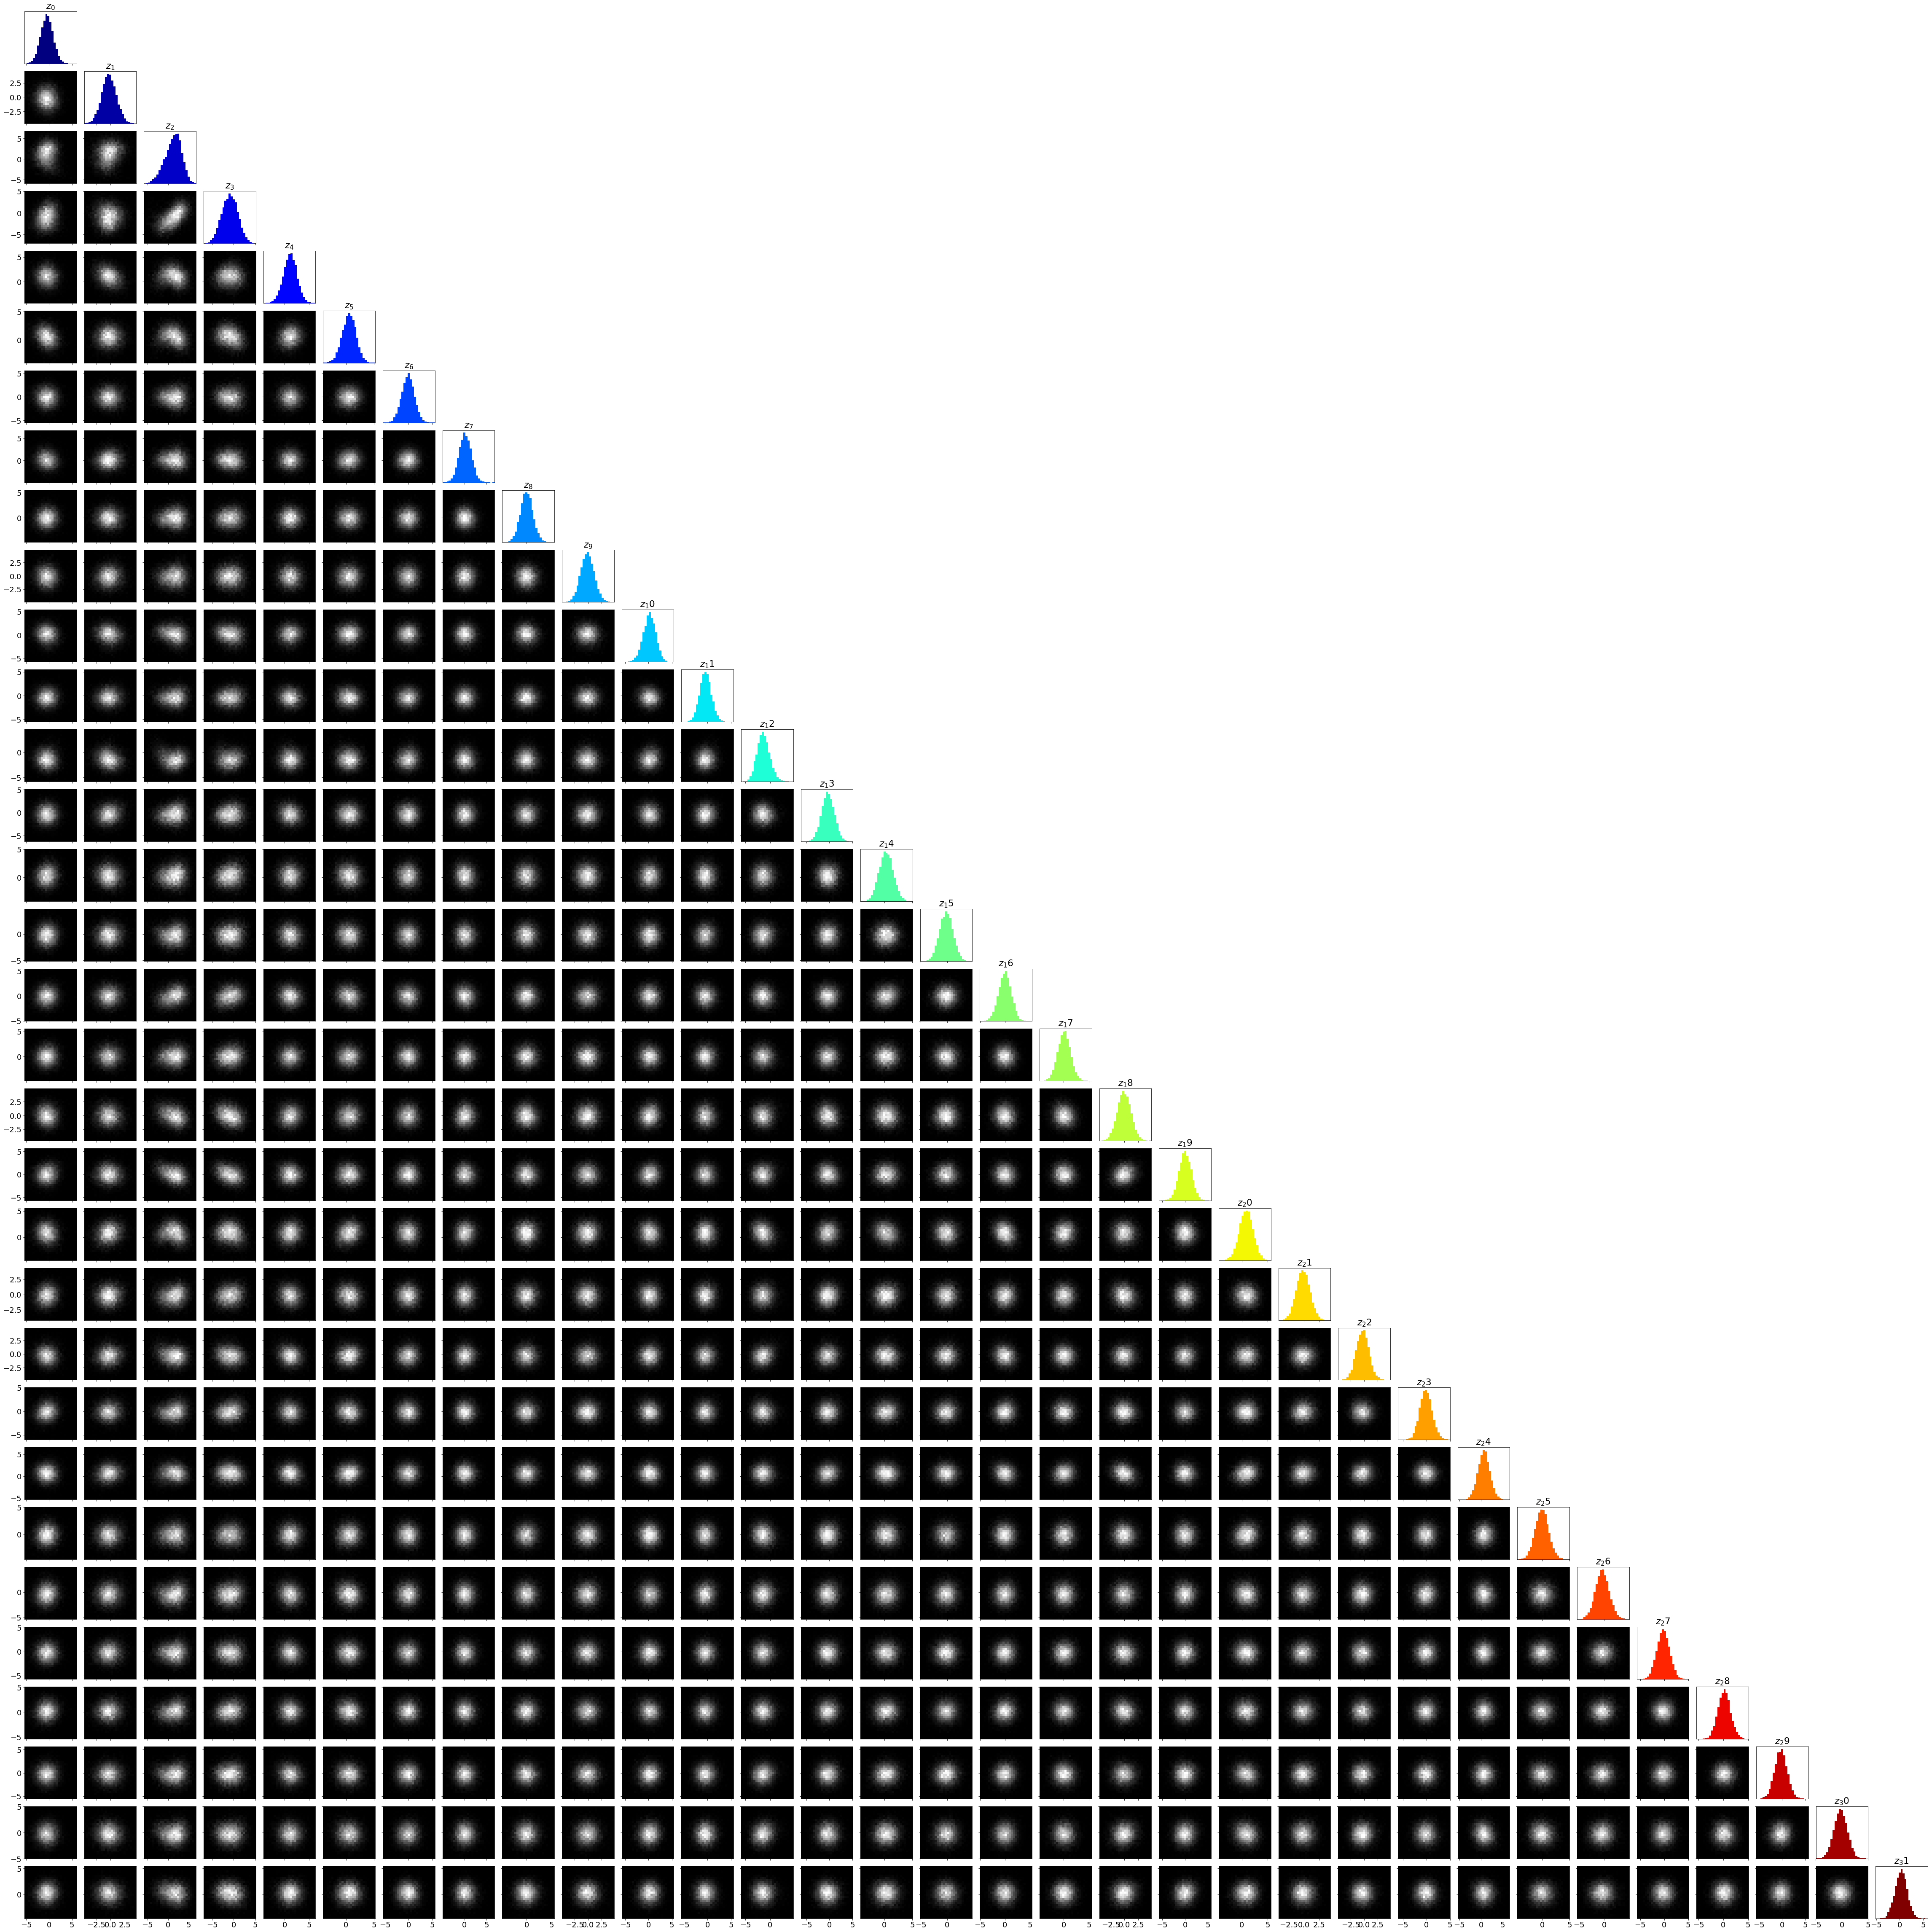

In [56]:
plot_corner_latent(z)

###### Comparison to latent space of VAE used

In [65]:
vae_lsst_conv, encoder_LSST, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v8/mse/',6, folder= True) # v7 OK

In [72]:
z_lsst = []
for i in range (100):
    a = batch_gen.__getitem__(2)
    output_enc = encoder_LSST.predict(a[0], batch_size = batch_size)
    z_lsst.append(sampling(output_enc))

In [73]:
z_lsst = np.concatenate(z_lsst, axis = 0)

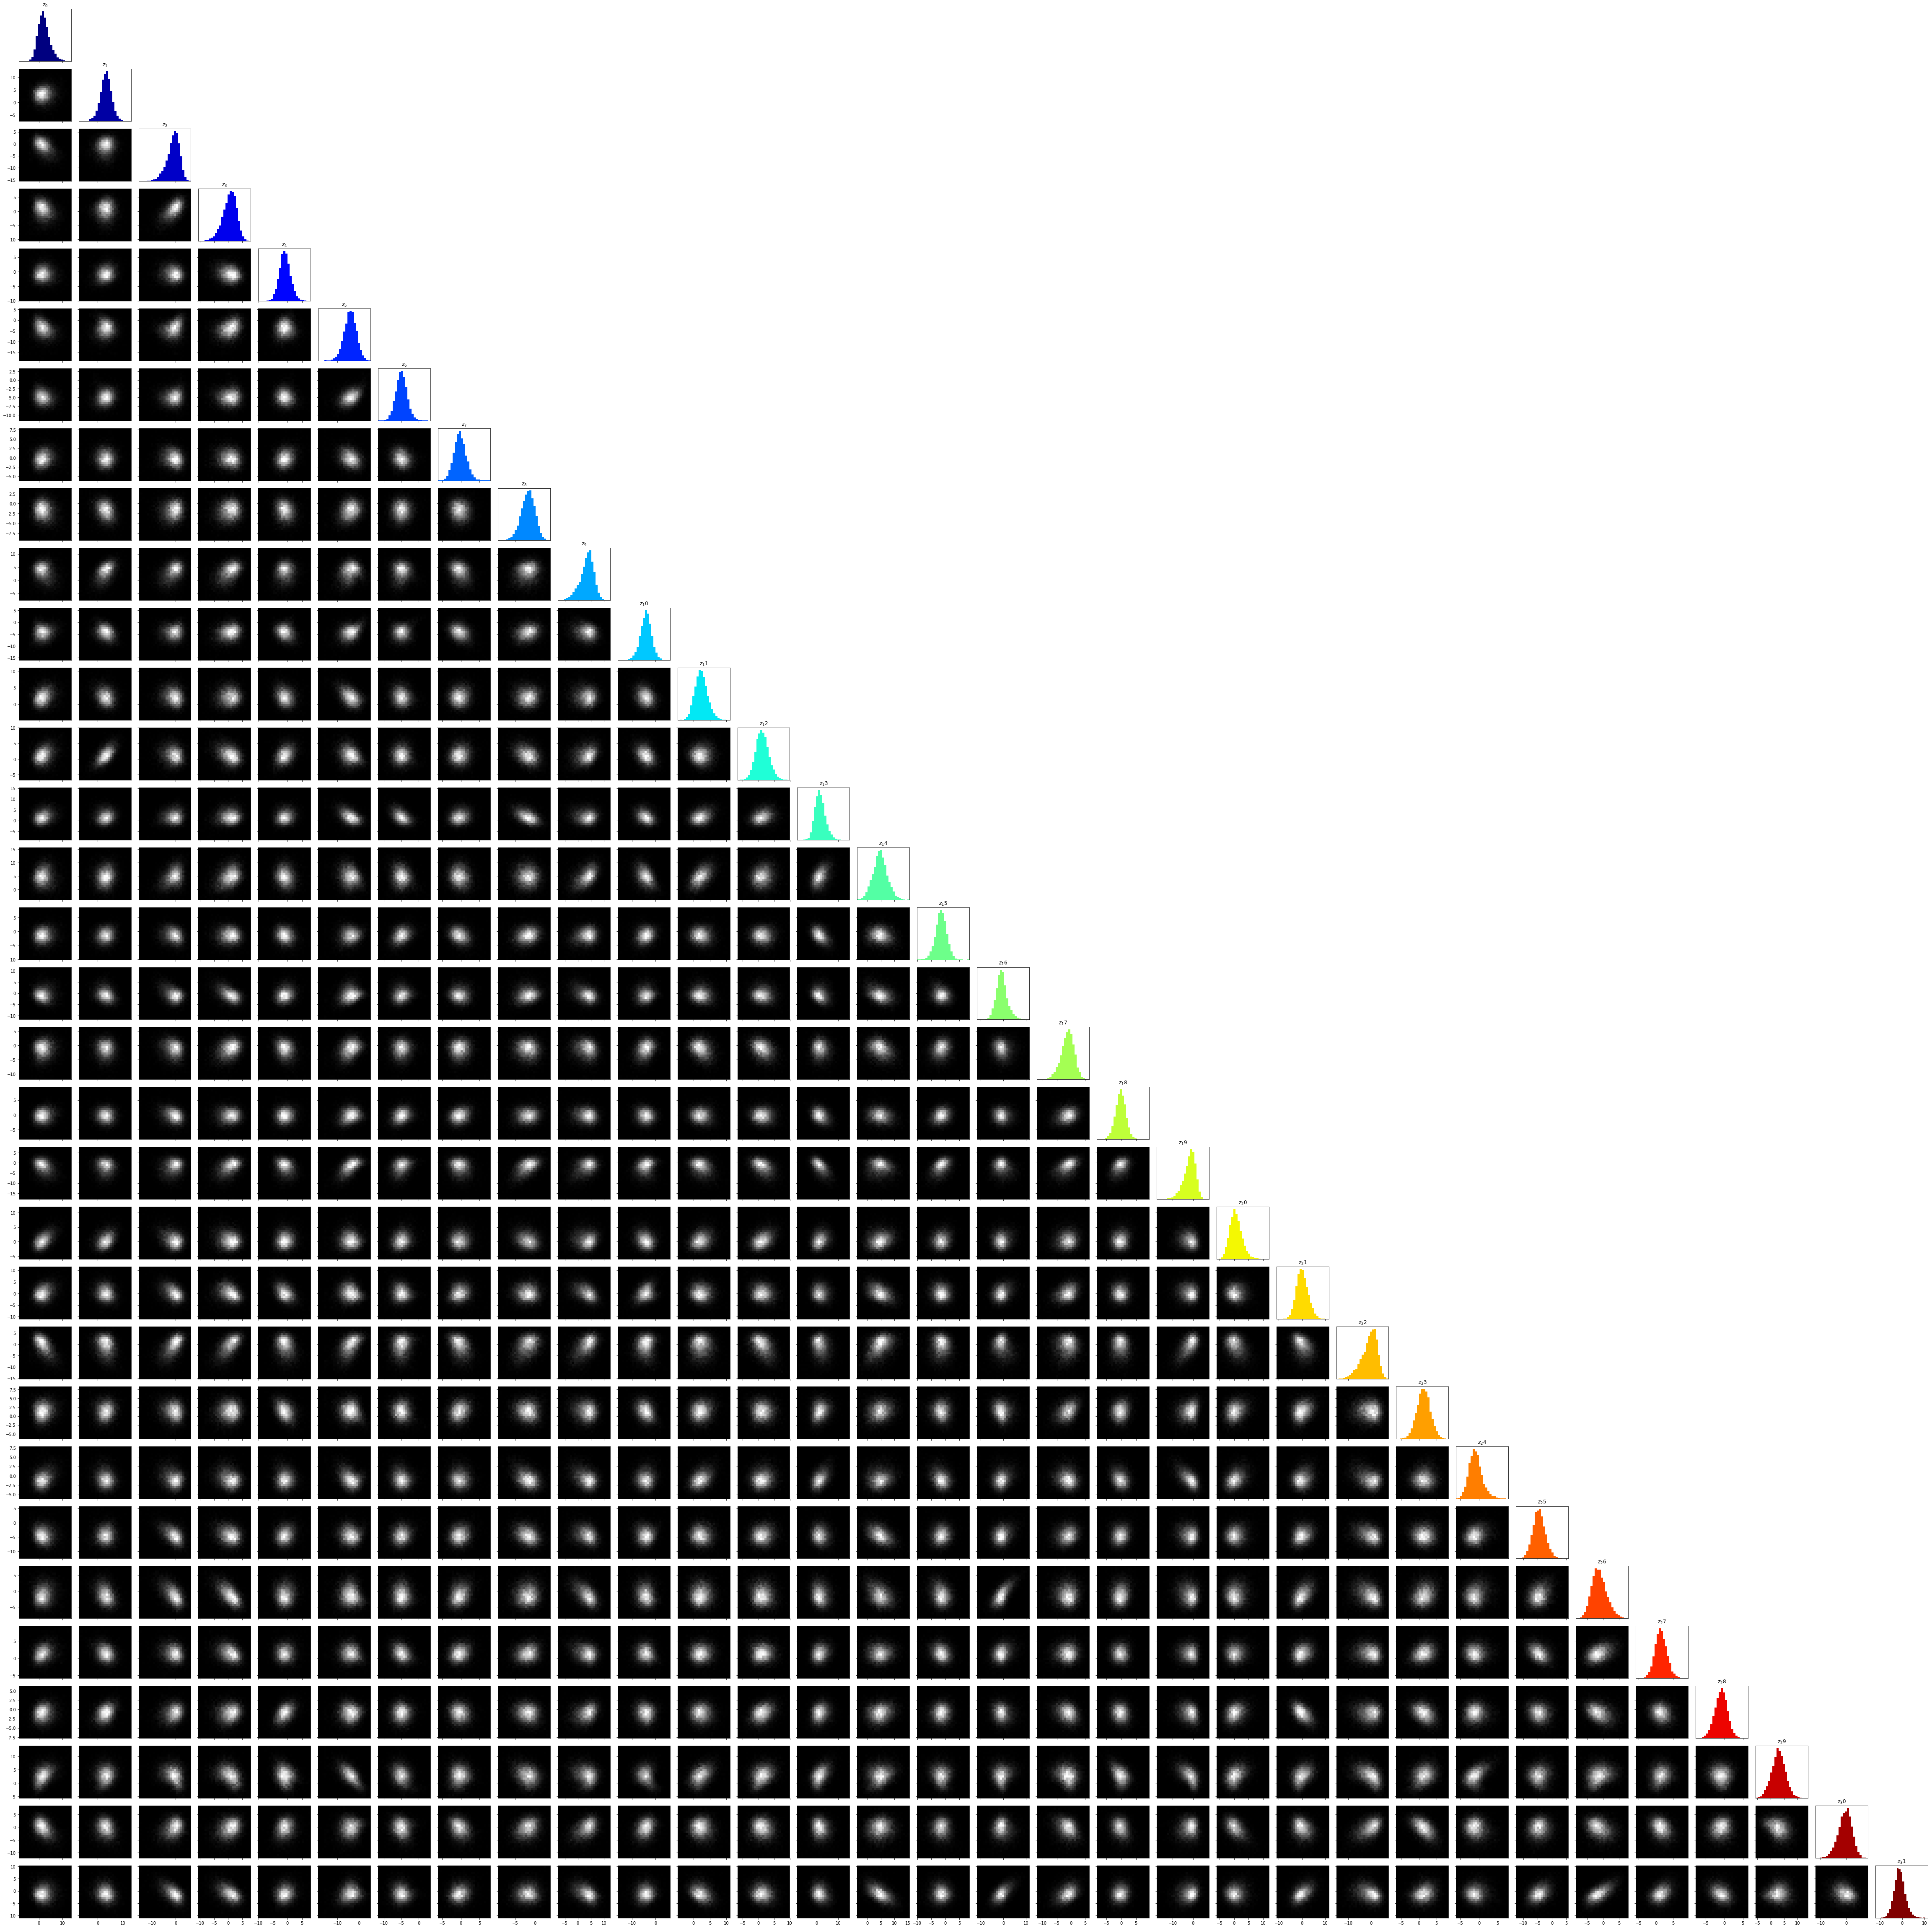

In [74]:
plot_corner_latent(z_lsst)

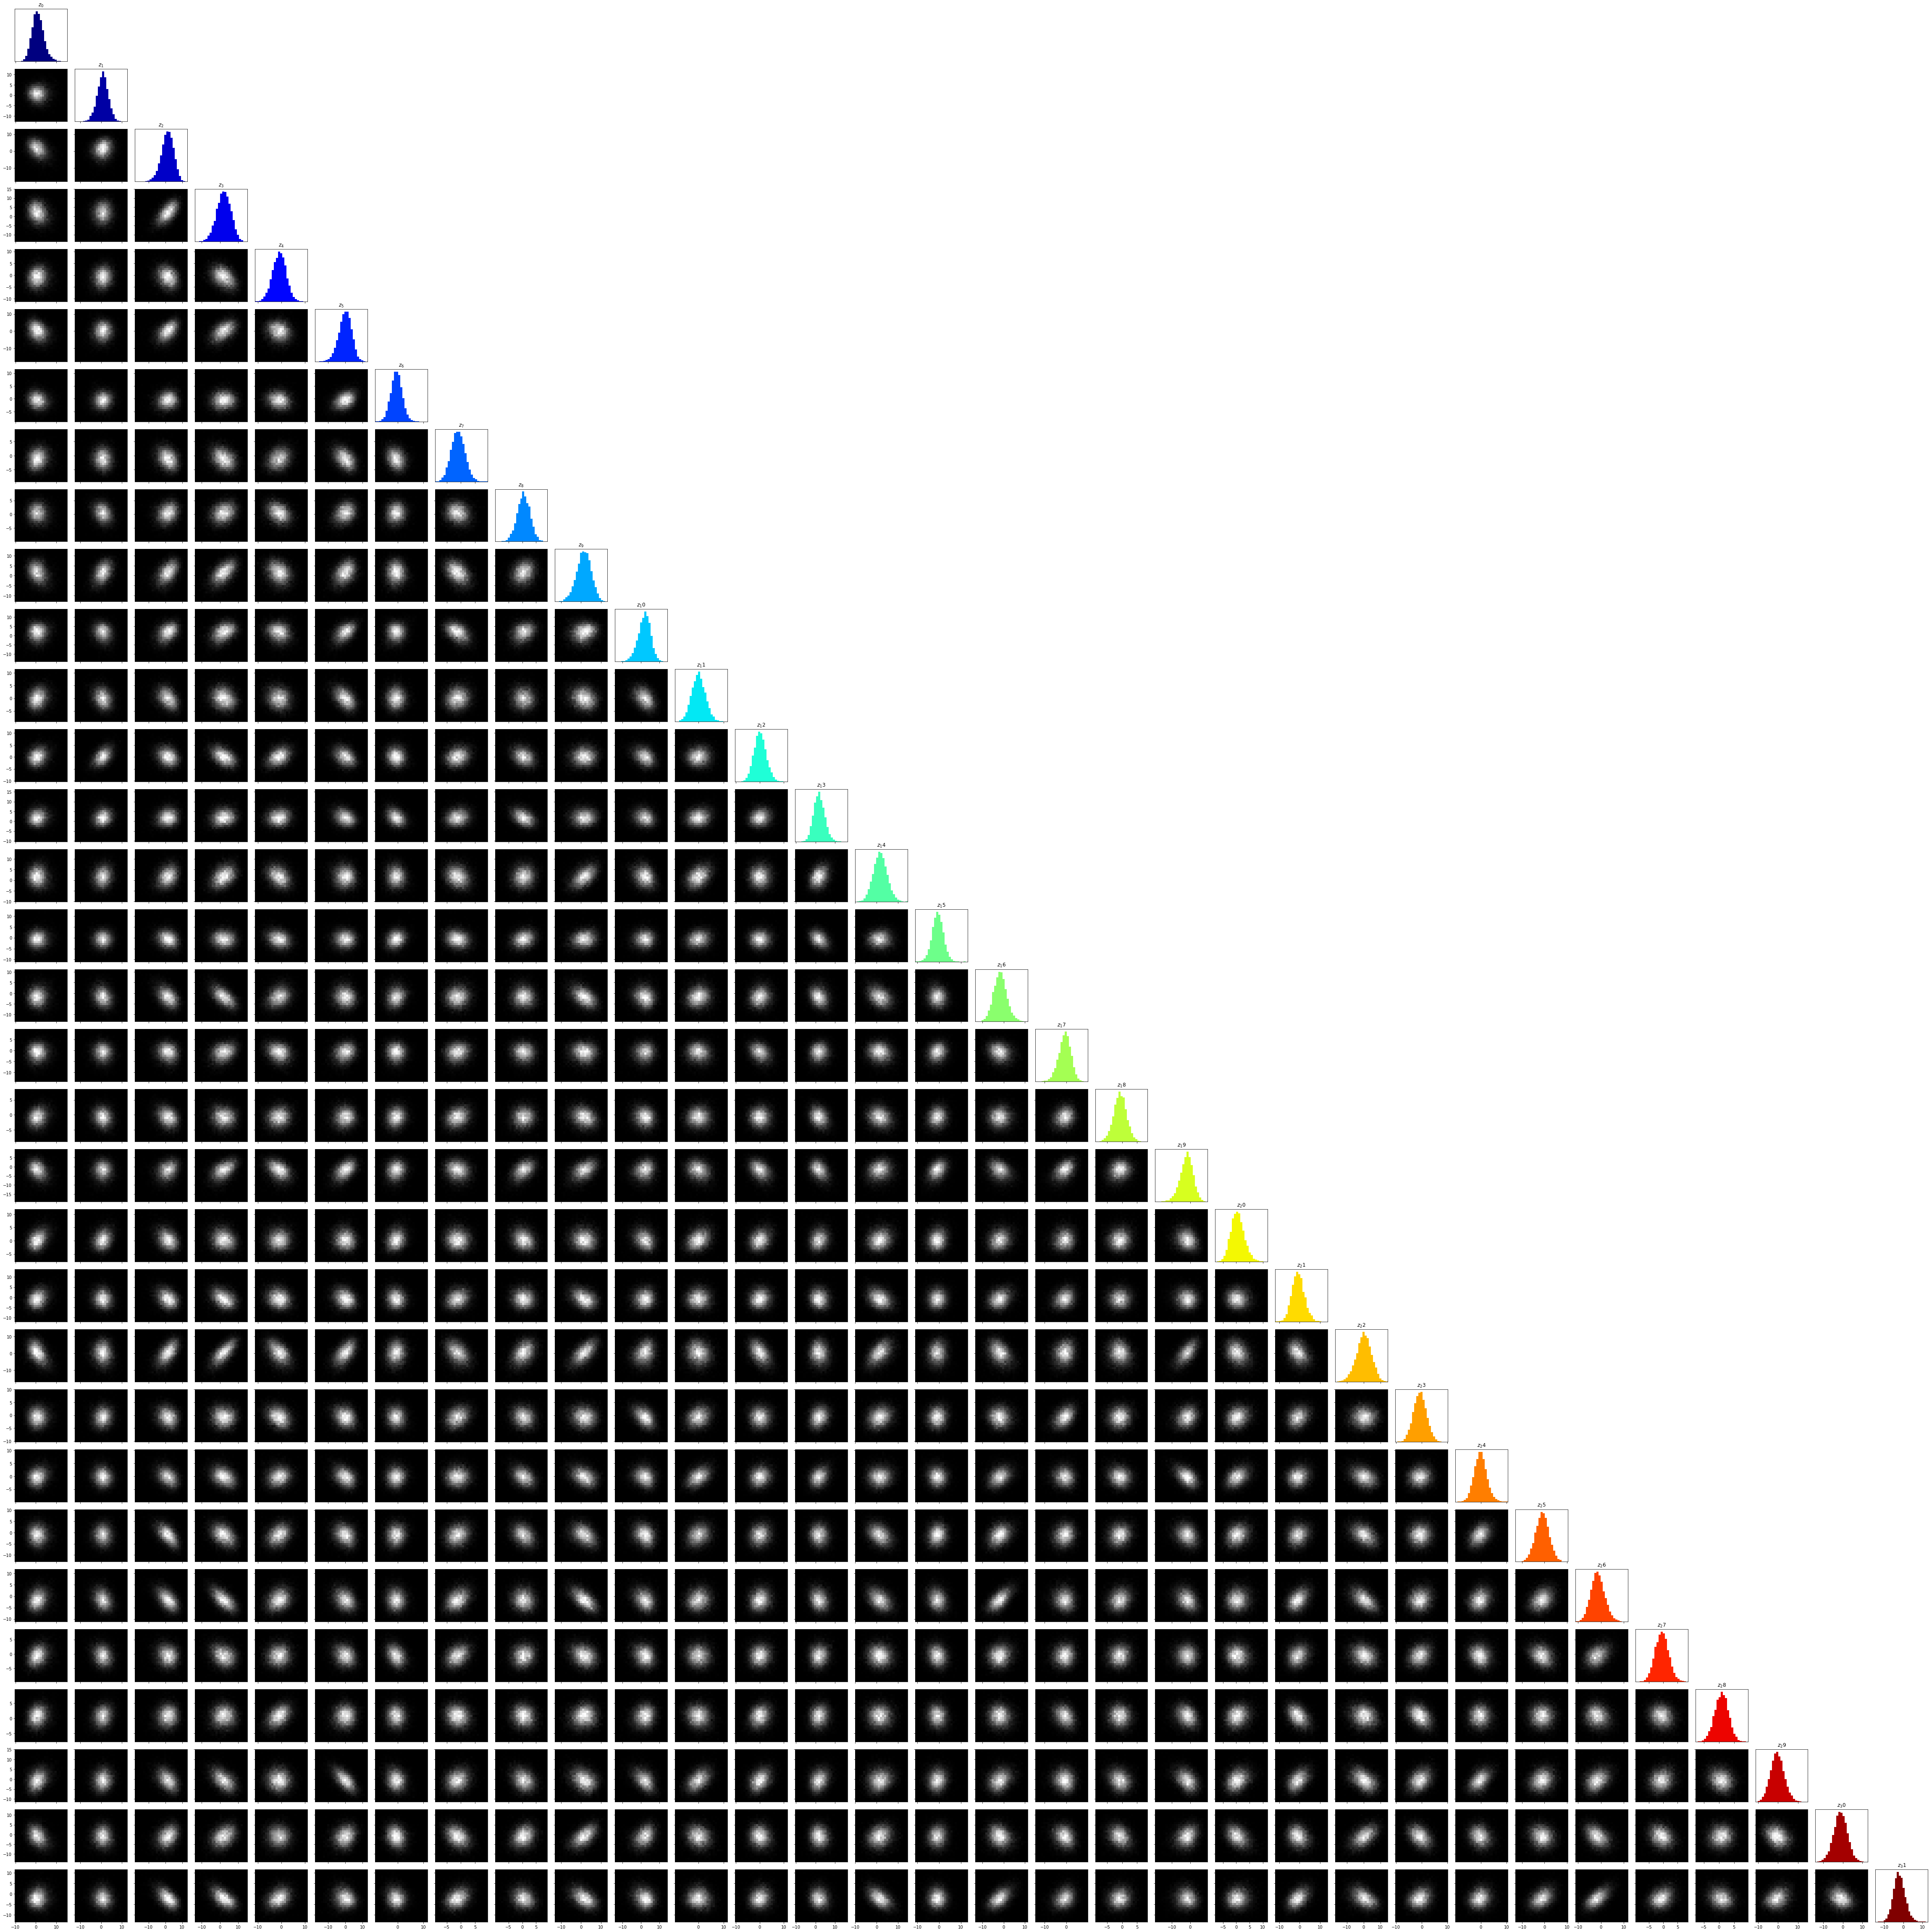

In [75]:
plot_corner_latent(z_lsst-z)

In [84]:
np.min(z_lsst[0]-z[0]), np.max(z_lsst[0]-z[0])

(-8.641119052998025, 6.81392780192953)

Text(0.5, 1.0, 'Latent space VAE')

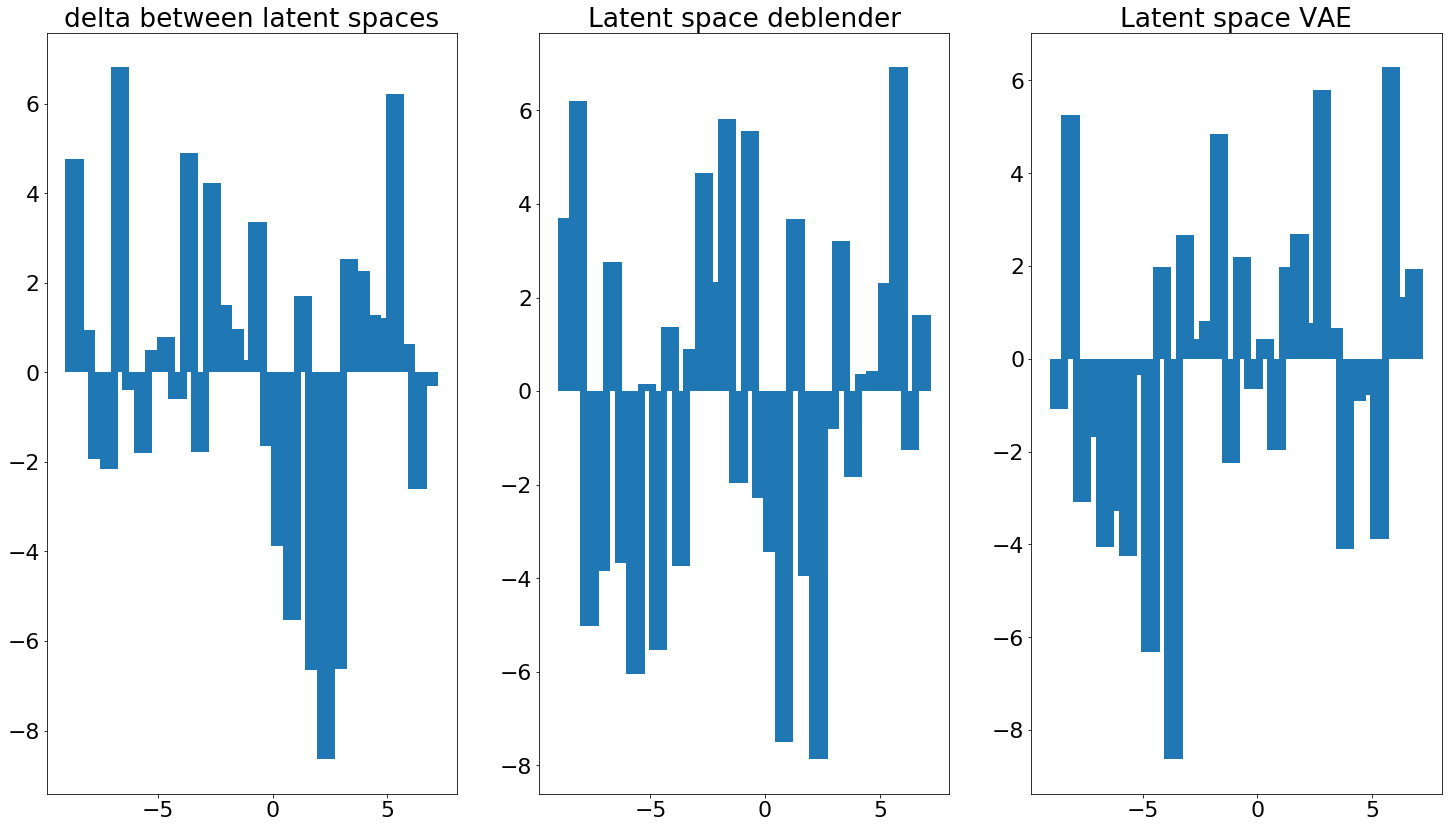

In [90]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

x = np.linspace(np.min(z_lsst[0]-z[0]), np.max(z_lsst[0]-z[0]),32)


fig, axes = plt.subplots(1,3, figsize=(25,14))

ax = axes[0]
_ = ax.bar(x,z_lsst[0]-z[0])
ax.set_title('delta between latent spaces')

ax = axes[1]
_ = ax.bar(x,z_lsst[0])
ax.set_title('Latent space deblender')

ax = axes[2]
_ = ax.bar(x,z[0])
ax.set_title('Latent space VAE')


# LSST + Euclid

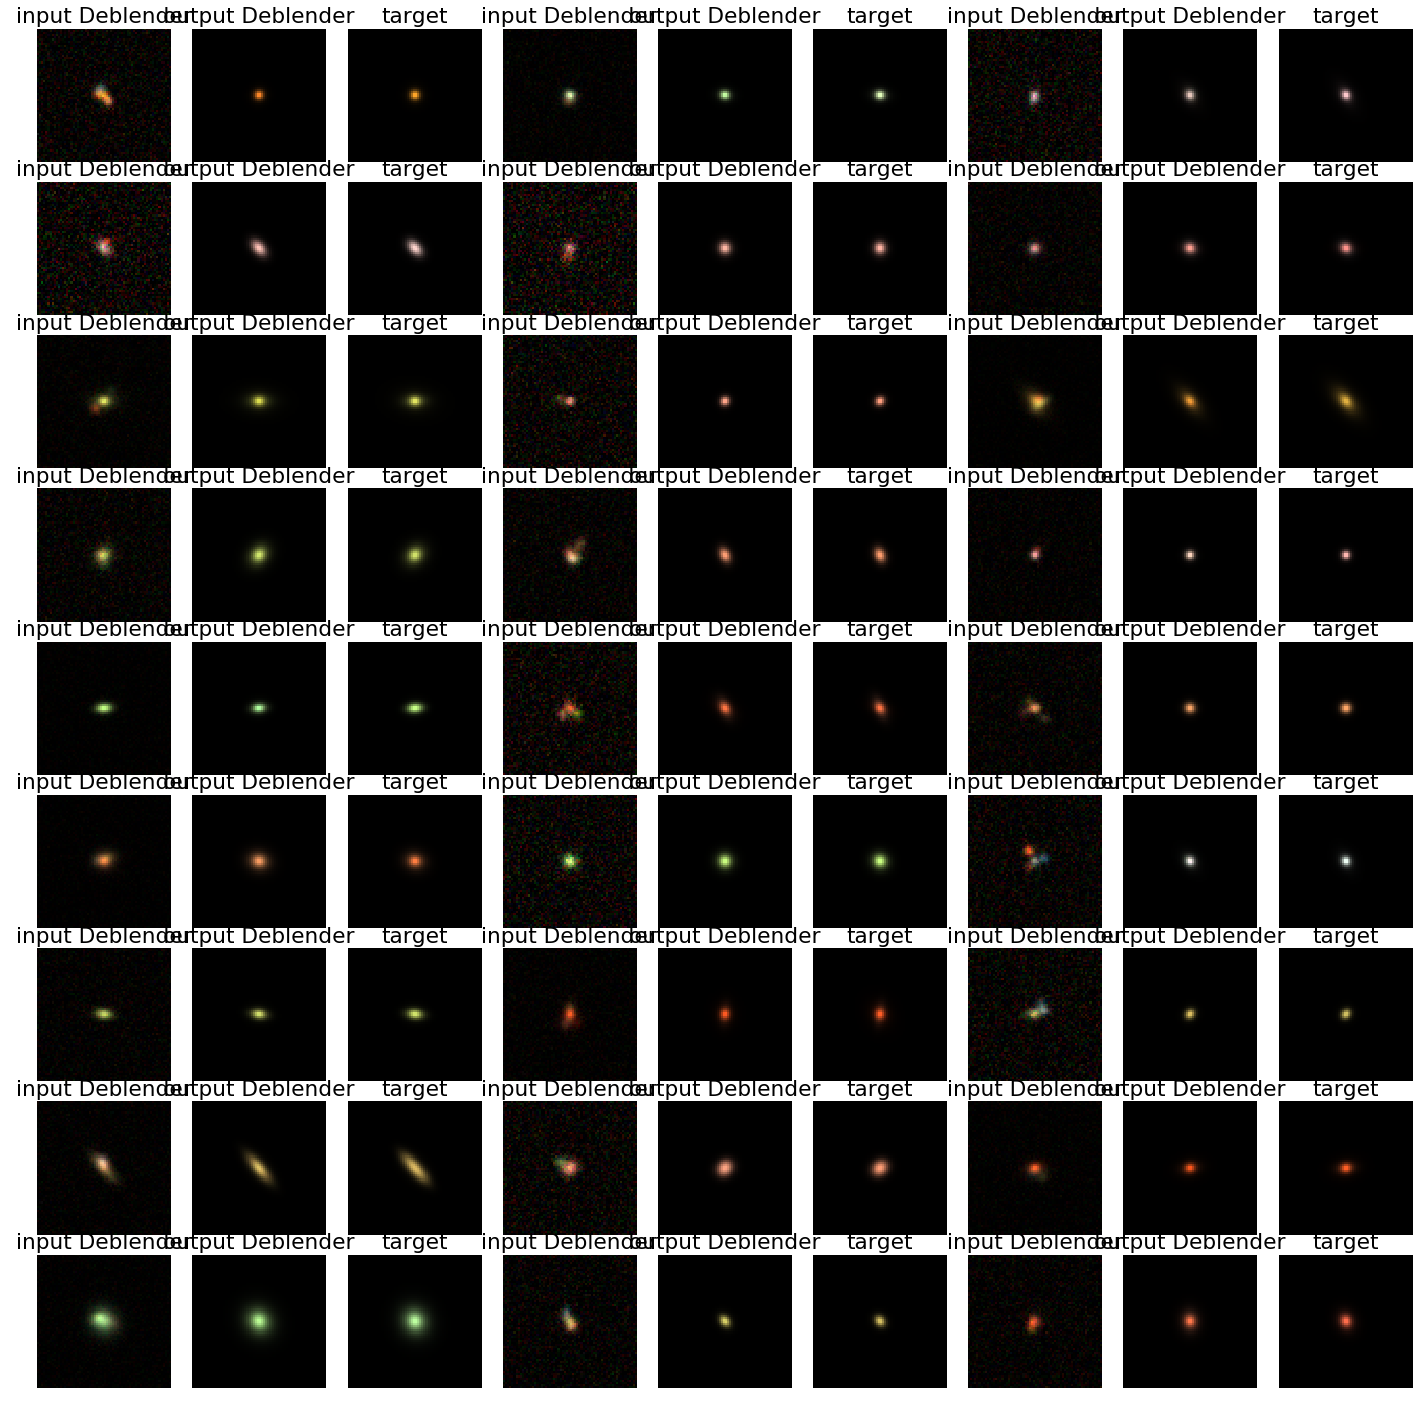

In [48]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst_euclid = batch_gen_lsst_euclid.__getitem__(2)
input_noisy = input_lsst_euclid[0]
input_noiseless = input_lsst_euclid[1]

output_deblender_lsst_euclid = deblender_lsst_euclid.predict(input_lsst_euclid[0], batch_size = 100)

output_deblender_lsst_euclid = denorm(output_deblender_lsst_euclid, bands_lsst_euclid, channel_last = True)
input_noisy = denorm(input_noisy, bands_lsst_euclid, channel_last = True)
input_noiseless = denorm(input_noiseless, bands_lsst_euclid, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst_euclid(input_noisy[indices[i*N_plot+j]],stamp_size, axes[i,j])#input_vae
        plot_rgb_lsst_euclid(output_deblender_lsst_euclid[indices[i*N_plot+j]],stamp_size, axes[i,j+1])#output_vae
        plot_rgb_lsst_euclid(input_noiseless[indices[i*N_plot+j]],stamp_size, axes[i,j+2])#output_vae

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

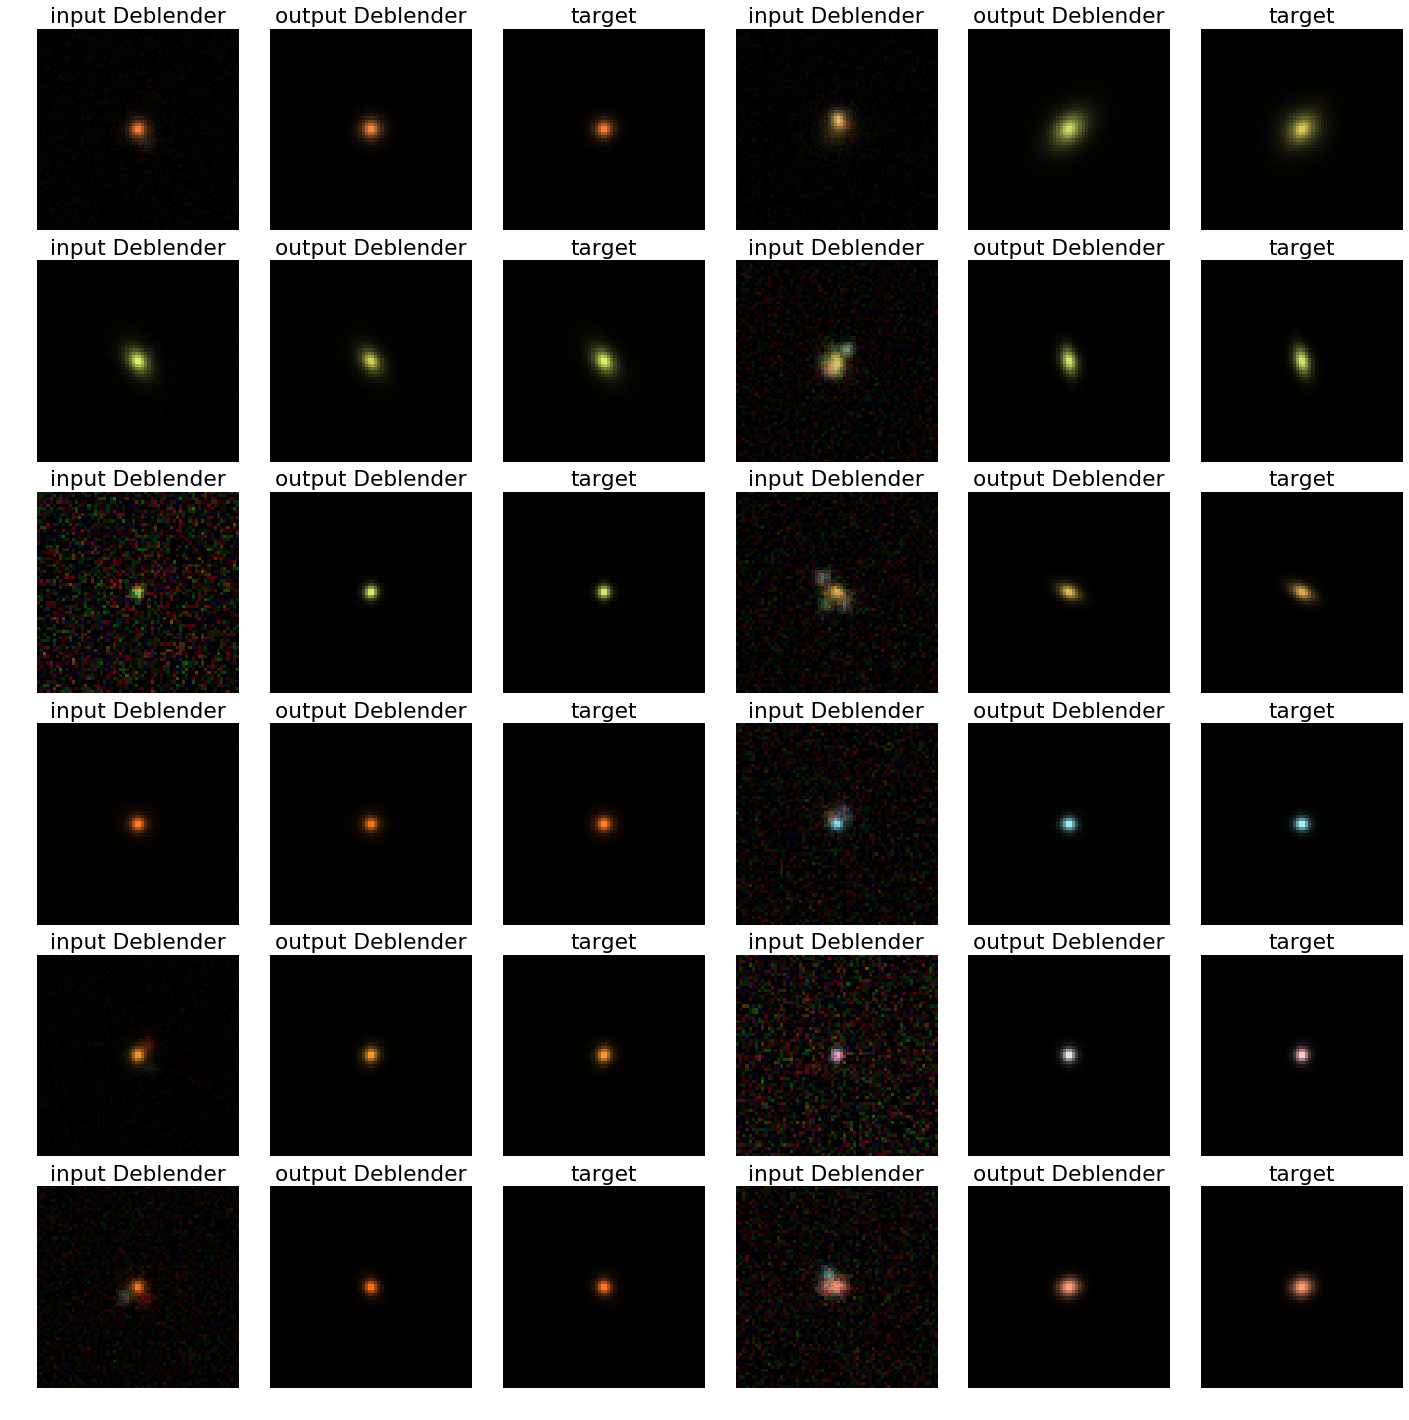

In [49]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst_euclid = batch_gen_lsst_euclid.__getitem__(2)
input_noisy = input_lsst_euclid[0]
input_noiseless = input_lsst_euclid[1]

output_deblender_lsst_euclid = deblender_lsst_euclid.predict(input_lsst_euclid[0], batch_size = 100)

output_deblender_lsst_euclid = denorm(output_deblender_lsst_euclid, bands_lsst_euclid, channel_last = True)
input_noisy = denorm(input_noisy, bands_lsst_euclid, channel_last = True)
input_noiseless = denorm(input_noiseless, bands_lsst_euclid, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst_euclid(input_noisy[indices[i*N_plot+j]],stamp_size, axes[i,j])#input_vae
        plot_rgb_lsst_euclid(output_deblender_lsst_euclid[indices[i*N_plot+j]],stamp_size, axes[i,j+1])#output_vae
        plot_rgb_lsst_euclid(input_noiseless[indices[i*N_plot+j]],stamp_size, axes[i,j+2])#output_vae

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

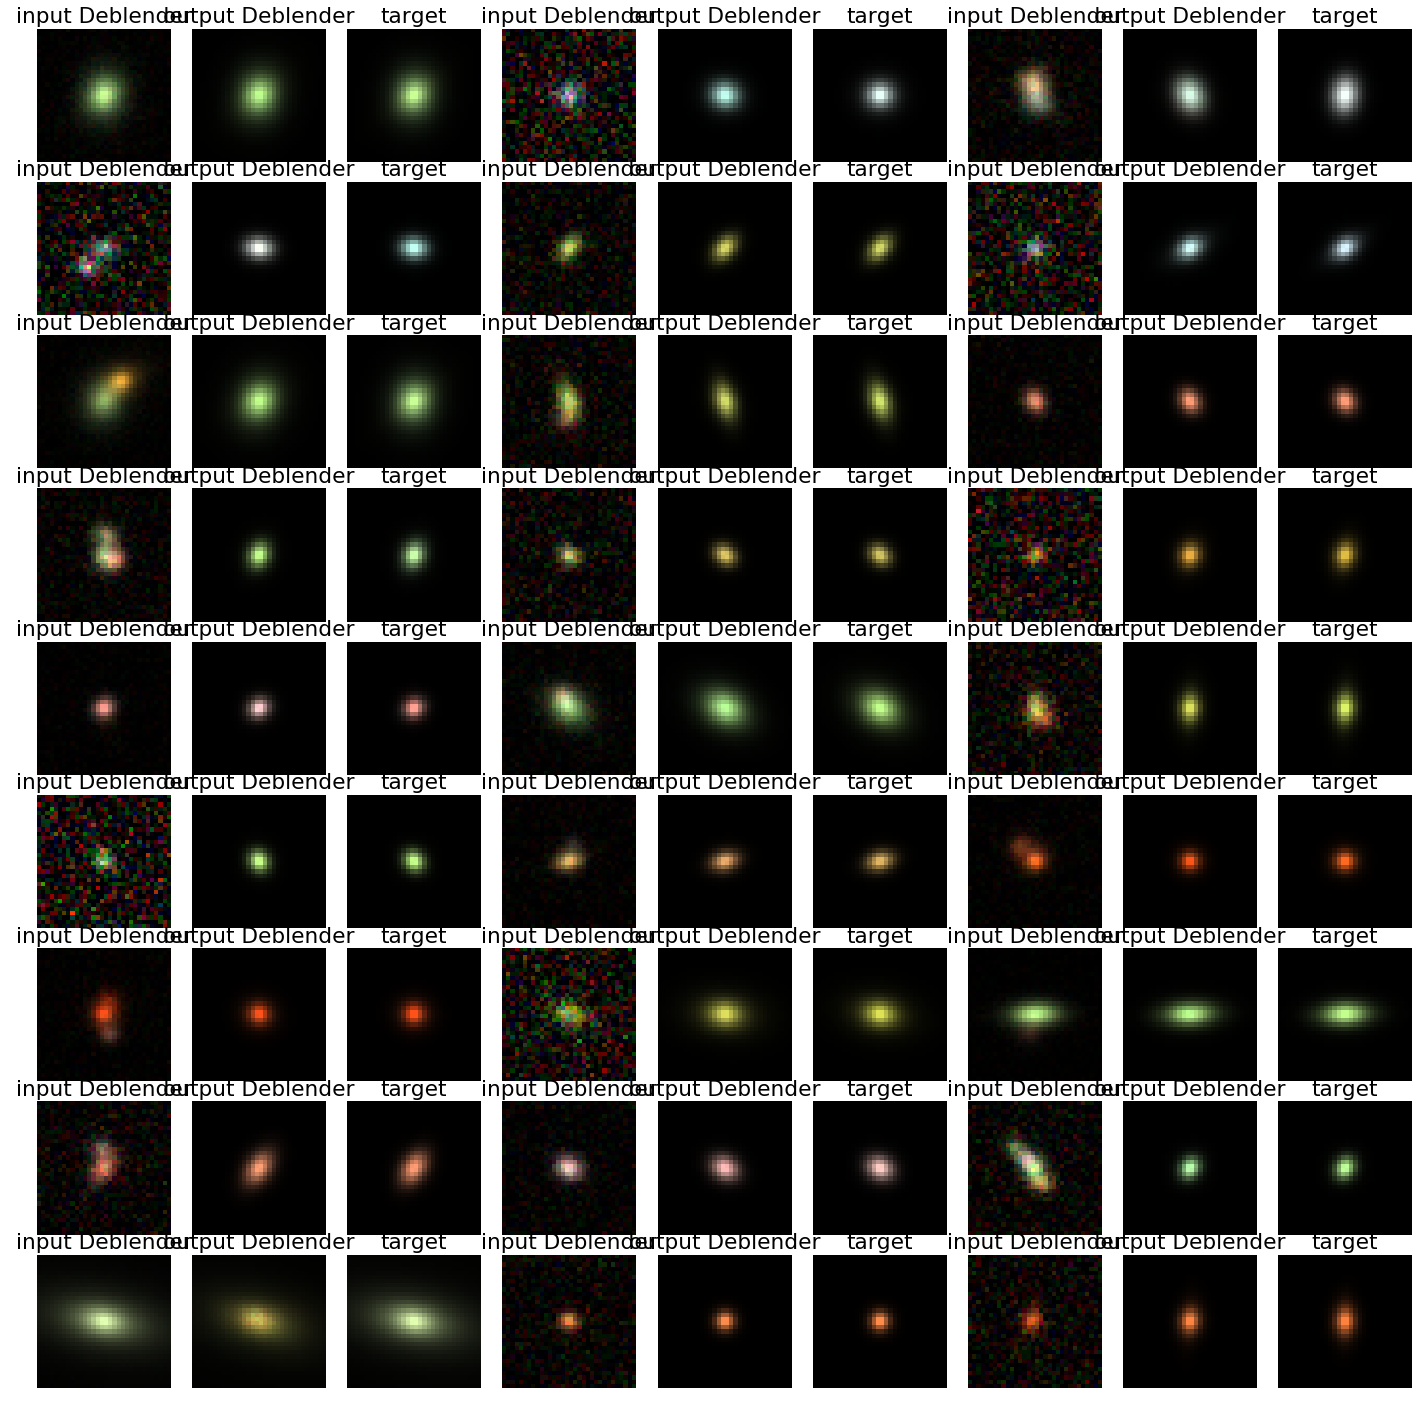

In [50]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst_euclid = batch_gen_lsst_euclid.__getitem__(2)
input_noisy = input_lsst_euclid[0]
input_noiseless = input_lsst_euclid[1]

output_deblender_lsst_euclid = deblender_lsst_euclid.predict(input_lsst_euclid[0], batch_size = 100)

output_deblender_lsst_euclid = denorm(output_deblender_lsst_euclid, bands_lsst_euclid, channel_last = True)
input_noisy = denorm(input_noisy, bands_lsst_euclid, channel_last = True)
input_noiseless = denorm(input_noiseless, bands_lsst_euclid, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst_euclid(input_noisy[indices[i*N_plot+j]][16:48,16:48,:],int(stamp_size/2), axes[i,j])#input_vae
        plot_rgb_lsst_euclid(output_deblender_lsst_euclid[indices[i*N_plot+j]][16:48,16:48,:],int(stamp_size/2), axes[i,j+1])#output_vae
        plot_rgb_lsst_euclid(input_noiseless[indices[i*N_plot+j]][16:48,16:48,:],int(stamp_size/2), axes[i,j+2])#output_vae

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

In [51]:
N = 100
batch_size = 100

ellipticities_lsst_euclid,e_beta_lsst_euclid, flux_in_lsst_euclid, flux_out_lsst_euclid, magnitudes_lsst_euclid, delta_r_lsst_euclid, delta_mag_lsst_euclid, max_blendedness_lsst_euclid, blend_total_lsst_euclid, SNR_lsst_euclid = deblender_processing(deblender_lsst_euclid, batch_gen_lsst_euclid,bands_lsst_euclid,6,stamp_size, N, batch_size)

In [58]:
#np.save('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_ellipticities_deb_lsst_euclid.npy', [ellipticities_lsst_euclid,e_beta_lsst_euclid])
#np.save('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_magnitudes_deb_lsst_euclid.npy', magnitudes_lsst_euclid)
#np.save('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_rest_deb_lsst_euclid.npy', [flux_in_lsst_euclid, flux_out_lsst_euclid, delta_r_lsst_euclid, delta_mag_lsst_euclid, max_blendedness_lsst_euclid, blend_total_lsst_euclid, SNR_lsst_euclid])

In [77]:
#ellipticities_lsst_euclid,e_beta_lsst_euclid = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_ellipticities_deb_lsst_euclid.npy')
#magnitudes_lsst_euclid = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_magnitudes_deb_lsst_euclid.npy')
#flux_in_lsst_euclid, flux_out_lsst_euclid, delta_r_lsst_euclid, delta_mag_lsst_euclid, max_blendedness_lsst_euclid, blend_total_lsst_euclid, SNR_lsst_euclid = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/results_rest_deb_lsst_euclid.npy')


In [52]:
delta_e_lsst_euclid =  e_beta_lsst_euclid[:,1,0] - e_beta_lsst_euclid[:,0,0]

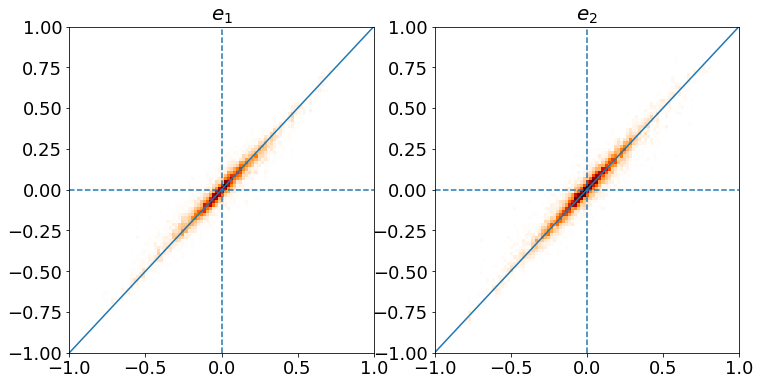

In [53]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_lsst_euclid[:,0,i], ellipticities_lsst_euclid[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'

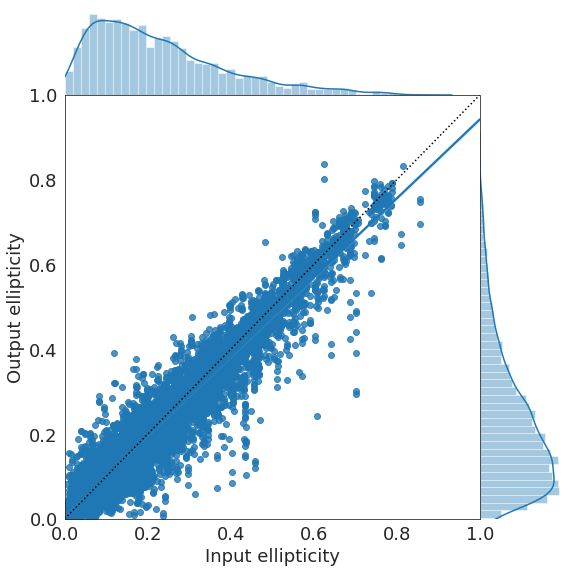

In [54]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
    
            g = sns.jointplot(e_beta_lsst_euclid[:,0,0], e_beta_lsst_euclid[:,1,0], kind='reg',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')


In [55]:
# Linear regression
slope_lsst_euclid, intercept_lsst_euclid, r_value_lsst_euclid, p_value_lsst_euclid, std_err_lsst_euclid = stats.linregress(e_beta_lsst_euclid[:,0,0], e_beta_lsst_euclid[:,1,0])

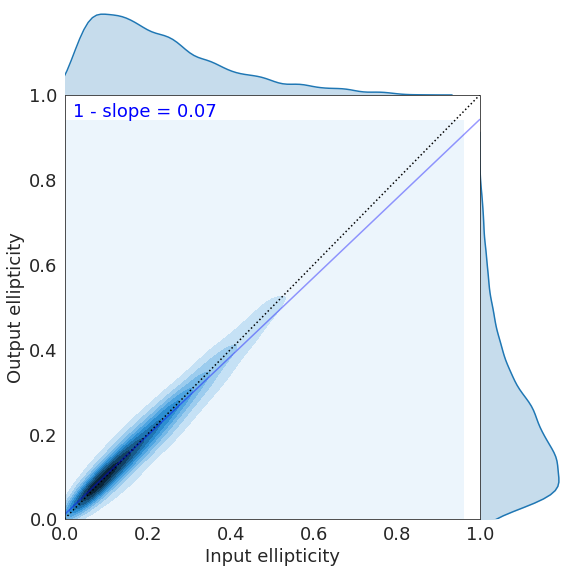

In [56]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
            
            g = sns.jointplot(e_beta_lsst_euclid[:,0,0], e_beta_lsst_euclid[:,1,0], kind='kde',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0,joint_kws={'shade_lowest':True}).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')
            g.ax_joint.plot(np.linspace(0, 1),
                            slope_lsst_euclid*np.linspace(0, 1)+intercept_lsst_euclid, color = 'b', alpha = 0.4)
            g.ax_joint.text(0.02, 0.95, '1 - slope = '+str(round(1-slope_lsst_euclid, 2)), color='b')

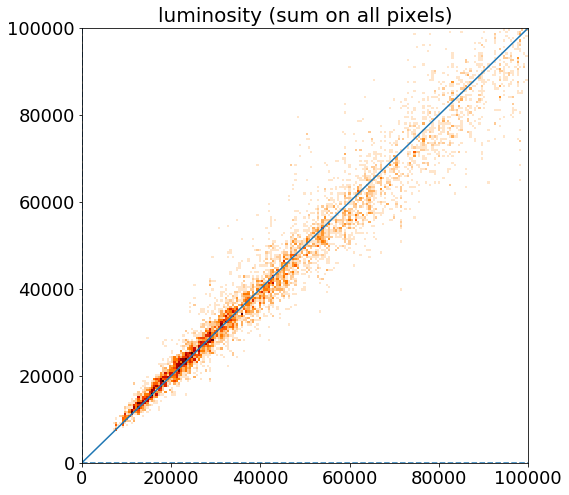

In [57]:
import matplotlib as mpl

max_lum = np.max(flux_in_lsst_euclid)

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(flux_in_lsst_euclid, flux_out_lsst_euclid, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

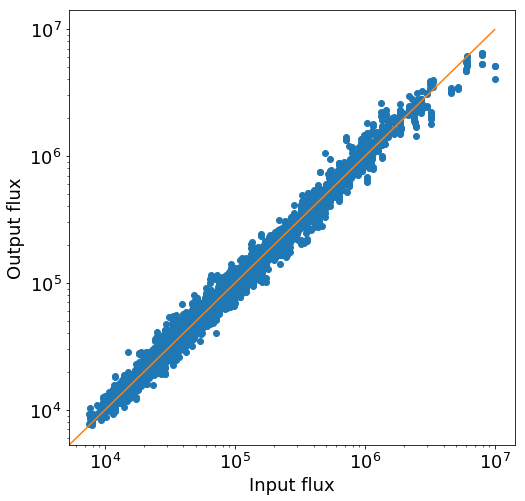

In [58]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = np.max(flux_in_lsst_euclid)
axes.plot(flux_in_lsst_euclid, flux_out_lsst_euclid,'o')

axes.plot([-emax,+emax],[-emax,+emax])
#axes.axhline(y=0, ls='--')
#axes.axvline(x=0, ls='--')
#axes.set_title('luminosity (sum on all pixels)')#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlabel('Input flux')
axes.set_ylabel('Output flux')
axes.set_xscale('log')
axes.set_yscale('log')

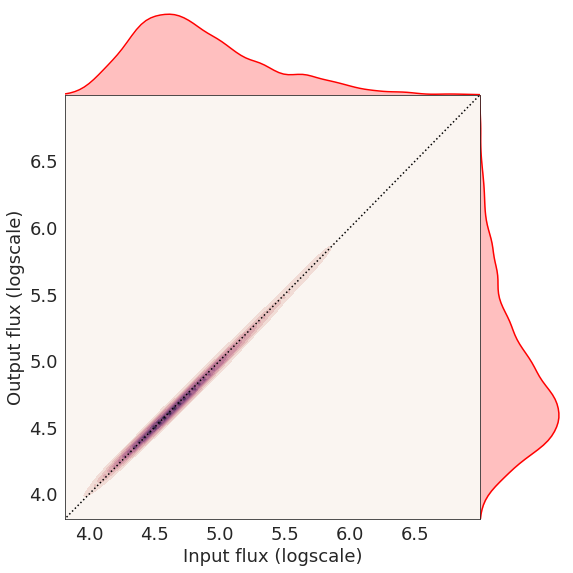

In [59]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
with sns.axes_style('white'):
            g = sns.jointplot(np.log10(flux_in_lsst_euclid), np.log10(flux_out_lsst_euclid), kind='kde',height =8,
                              xlim =[np.min(np.log10(flux_in_lsst_euclid-1000)), np.max(np.log10(flux_in_lsst_euclid))], ylim=[np.min(np.log10(flux_in_lsst_euclid-1000)), np.max(np.log10(flux_in_lsst_euclid))],cmap=cmap,color = 'red', space=0).set_axis_labels('Input flux (logscale)', 'Output flux (logscale)')
            #g.ax_joint.set_xscale('log')#color = sns.xkcd_rgb["dark green"],
            #g.ax_joint.set_yscale('log')
            g.ax_joint.plot(np.linspace(-1, np.max(np.log10(flux_in_lsst_euclid))),
                            np.linspace(-1, np.max(np.log10(flux_in_lsst_euclid))), ':k')

Test in all filters

In [30]:
N = 100

generator = batch_gen_lsst_euclid
deblender = deblender_lsst_euclid
bands = bands_lsst_euclid
im_size = stamp_size
batch_size = 100

In [31]:
N = 100

generator = batch_gen_lsst_euclid
deblender = deblender_lsst_euclid
bands = bands_lsst_euclid
im_size = stamp_size
batch_size = 100

flux_in_all_bands_lsst_euclid = np.empty([N,batch_size,10],dtype='float32')
flux_out_all_bands_lsst_euclid= np.empty([N,batch_size,10], dtype='float32')
for j in range(N):
    input_vae = generator.__getitem__(2)
    output_vae = deblender.predict(input_vae[0], batch_size = batch_size)
    output_vae = utils.denorm(output_vae, bands, channel_last = True)
    input_noiseless = utils.denorm(input_vae[1], bands, channel_last = True)

    for i in range (len(input_vae[0])):
        for k in range (len(input_noiseless[i][0,0])):
            # Measurement of fluxes
            mask = plot.createCircularMask(im_size,im_size,None,5)
            masked_img_in_simple = input_noiseless[i][:,:,k].copy()
            masked_img_in_simple[~mask] = 0  

            masked_img_out_simple = output_vae[i][:,:,k].copy()
            masked_img_out_simple[~mask] = 0

            # Calculate the luminosity by substracting the noise
            flux_in_all_bands_lsst_euclid[j,i,k] = np.sum(masked_img_in_simple)
            flux_out_all_bands_lsst_euclid[j,i,k] = np.sum(masked_img_out_simple)


In [32]:
np.save('flux_lsst_euclid_deb.npy',flux_out_all_bands_lsst_euclid )

In [40]:
flux_in_all_bands_lsst_euclid.shape

(100, 100, 10)

In [56]:
flux_in_all_bands_lsst_euclid = np.concatenate(flux_in_all_bands_lsst_euclid, axis =0)
flux_out_all_bands_lsst_euclid = np.concatenate(flux_out_all_bands_lsst_euclid, axis =0)

In [63]:
print(flux_in_all_bands_lsst_euclid.shape, flux_out_all_bands_lsst_euclid.shape)

(10000, 10) (10000, 10)


In [60]:
flux_out_all_bands_lsst_euclid = np.concatenate(flux_out_all_bands_lsst_euclid, axis =0)

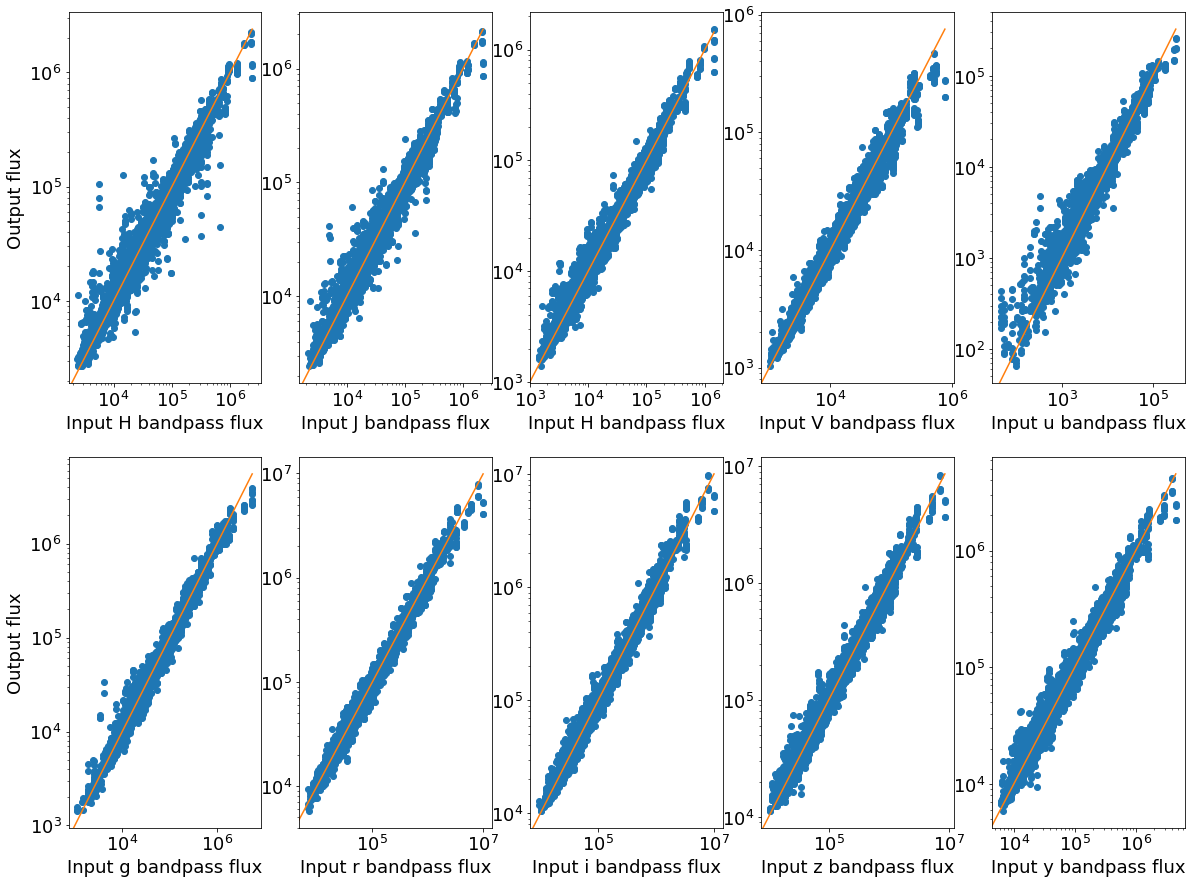

In [71]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

import matplotlib as mpl

N = 5
fig, axes = plt.subplots(2,N, figsize=(20,15))

filter_names_all = 'HJHVugrizy'

j = 0
i = 0

for filter_name in filter_names_all:
    ax = axes[j,i]
    ax.plot(flux_in_all_bands_lsst_euclid[:,i+j*N], flux_out_all_bands_lsst_euclid[:,i+j*N],'o')
    emax = np.max(flux_in_all_bands_lsst_euclid[:,i+j*N])
    ax.plot([-emax,+emax],[-emax,+emax])
    ax.spines['bottom']
    ax.spines['right']
    ax.spines['left']
    ax.spines['top']
    ax.xaxis.label
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    if i == 0 or i == 5:
        ax.set_ylabel('Output flux')
    ax.set_xlabel('Input {0} bandpass flux'.format(filter_name))
    ax.set_xscale('log')
    ax.set_yscale('log')
    if i == 4:
        j = 1
        i = 0
    else:
        i+=1

## Delta e as function of delta magnitude, SNR and blend rate

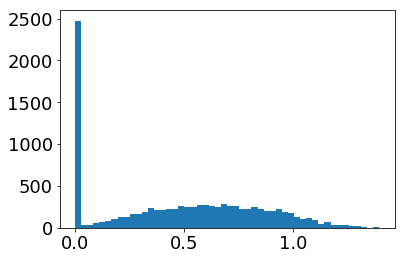

In [114]:
_ = plt.hist(delta_r_lsst_euclid, bins = 50)

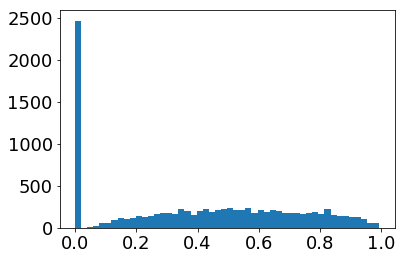

In [115]:
_ = plt.hist(max_blendedness_lsst_euclid, bins = 50)

In [116]:
np.where(max_blendedness_lsst_euclid > 0.95)[0].shape

(139,)

Function of SNR

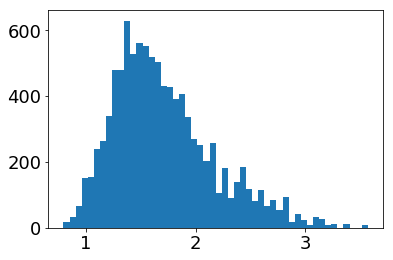

In [64]:
_ = plt.hist(np.log10(SNR_lsst_euclid), bins = 50)

In [65]:
np.min(SNR_lsst_euclid)

6.239319790796819

In [42]:
input_lsst_euclid = batch_gen_lsst_euclid.__getitem__(2)

input_noiseless = input_lsst_euclid[1]
input_noisy = input_lsst_euclid[0]

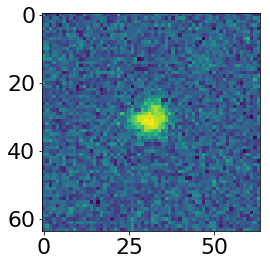

In [47]:
plt.imshow(input_noisy[6][:,:,6])

../../scripts/tools_for_VAE/tools_for_VAE/plot.py:56: RuntimeWarning: invalid value encountered in true_divide
  mean_y = ny/n
../../scripts/tools_for_VAE/tools_for_VAE/plot.py:58: RuntimeWarning: invalid value encountered in true_divide
  var_y = (ny2/n - mean_y**2)/n


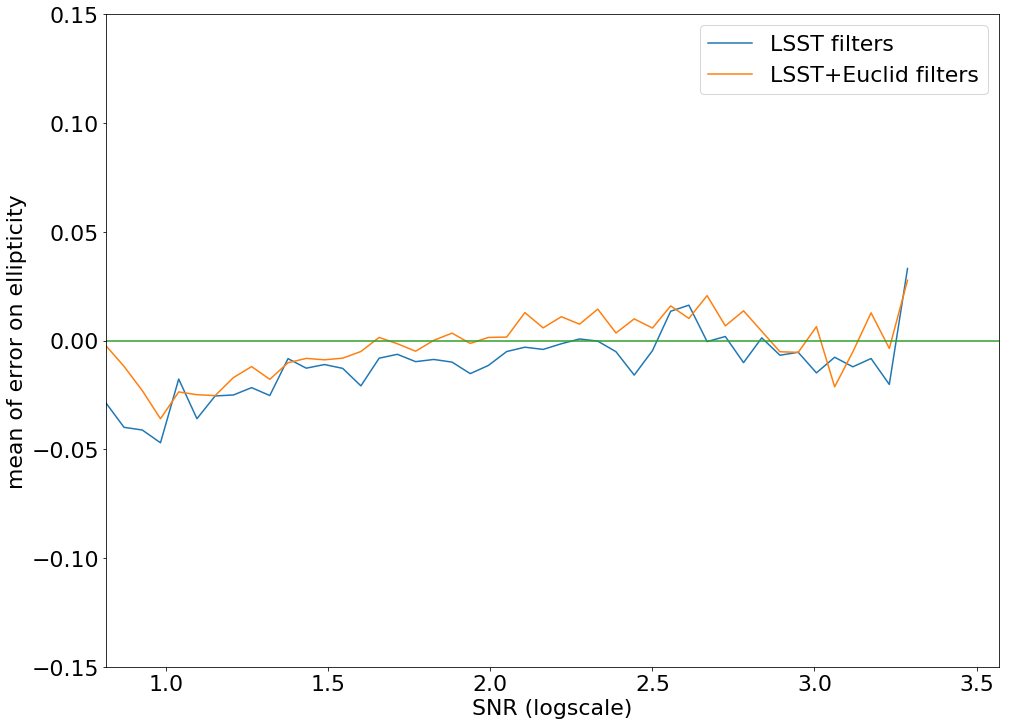

In [60]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,12))


mean_SNR_lsst, var_SNR_lsst = mean_var(np.log10(SNR_lsst),delta_e_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(np.log10(SNR_lsst_euclid),delta_e_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(np.log10(SNR_lsst_euclid)), np.max(np.log10(SNR_lsst_euclid)), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5


plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(np.log10(np.min(SNR_lsst)), np.log10(np.max(SNR_lsst)))
plt.ylim(-0.15, 0.15)

plt.xlabel('SNR (logscale)')
plt.ylabel('mean of error on ellipticity')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)

In [61]:
delta_flux_abs_lsst = (flux_out_lsst-flux_in_lsst)/flux_in_lsst
delta_flux_abs_lsst_euclid = (flux_out_lsst_euclid-flux_in_lsst_euclid)/flux_in_lsst_euclid

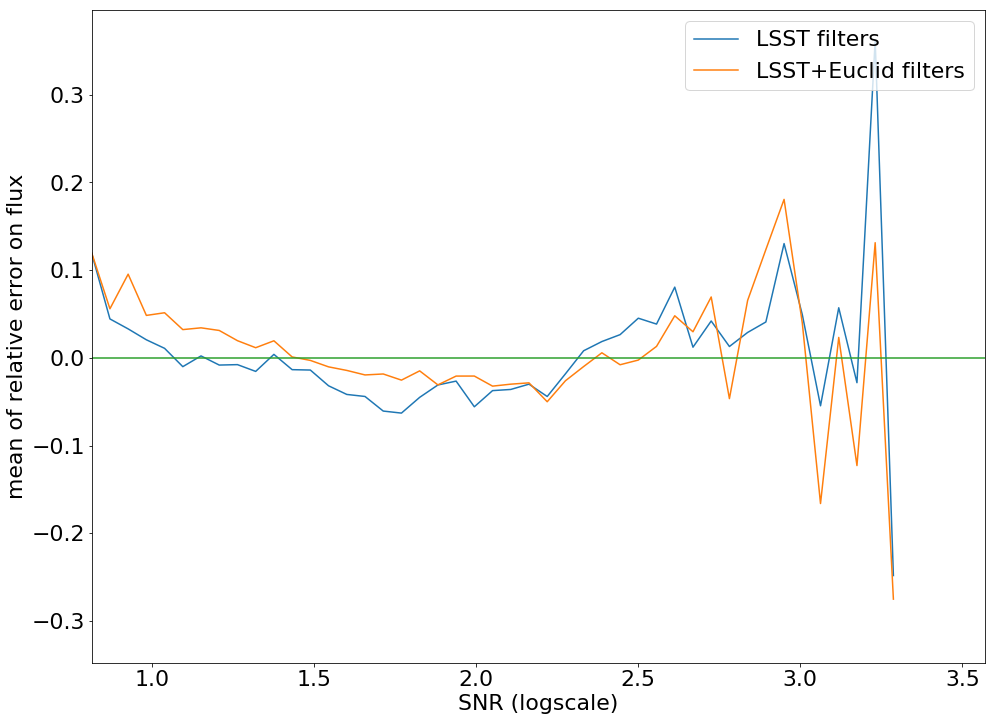

In [62]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,12))


mean_SNR_lsst, var_SNR_lsst = mean_var(np.log10(SNR_lsst),delta_flux_abs_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(np.log10(SNR_lsst_euclid),delta_flux_abs_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(np.log10(SNR_lsst_euclid)), np.max(np.log10(SNR_lsst_euclid)), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5


plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(np.log10(np.min(SNR_lsst)), np.log10(np.max(SNR_lsst)))
#plt.ylim(-0.15, 0.15)

plt.xlabel('SNR (logscale)')
plt.ylabel('mean of relative error on flux')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)

Function of blend rate

In [63]:
print("Mean of delta e for LSST filters: "+str(np.mean(delta_e_lsst)))
print("Mean of delta e for LSST + Euclid filters: "+str(np.mean(delta_e_lsst_euclid)))

Mean of delta e for LSST filters: -0.013147608054738164
Mean of delta e for LSST + Euclid filters: -0.005024978197961907


In [64]:
image_1 = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Image_generation/blend_0.2_max_blend.npy')
image_2 = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Image_generation/blend_0.52_max_blend.npy')
image_3 = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Image_generation/blend_0.73_max_blend.npy')

In [65]:
image_1[1][0]

0.20656037330627441

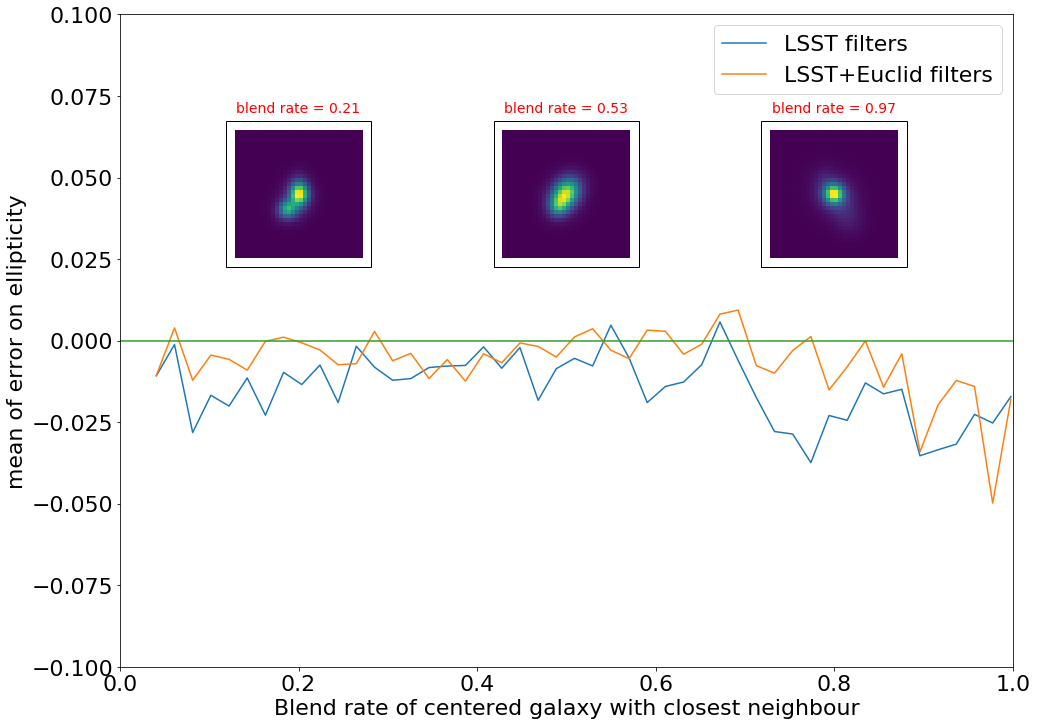

In [66]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,12))


mean_SNR_lsst, var_SNR_lsst = mean_var(max_blendedness_lsst,delta_e_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(max_blendedness_lsst_euclid,delta_e_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(max_blendedness_lsst_euclid), np.max(max_blendedness_lsst_euclid), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5


from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

imagebox = OffsetImage(image_1[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.2, 0.045))
axes.add_artist(ab)
axes.text(0.13, 0.07, 'blend rate = '+str(np.round(image_1[1][0], 2)), fontsize =14, color='r')

imagebox = OffsetImage(image_2[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.5, 0.045))
axes.add_artist(ab)
axes.text(0.43, 0.07, 'blend rate = '+str(np.round(image_2[1][0], 2)), fontsize =14, color='r')

imagebox = OffsetImage(image_3[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.8, 0.045))
axes.add_artist(ab)
axes.text(0.73, 0.07, 'blend rate = '+str(np.round(image_3[1][0], 2)), fontsize =14, color='r')

plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 1)
plt.ylim(-0.1, 0.1)

plt.xlabel('Blend rate of centered galaxy with closest neighbour')
plt.ylabel('mean of error on ellipticity')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


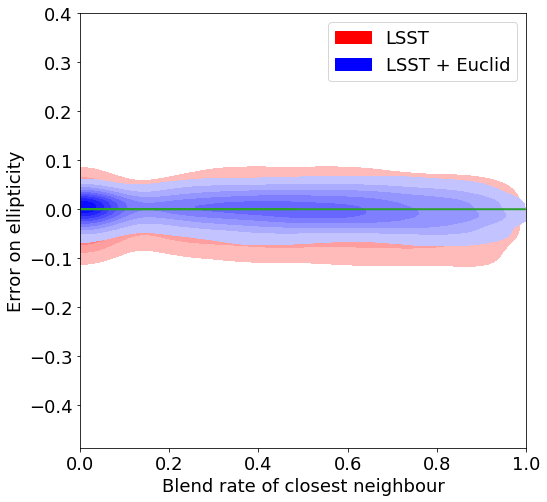

In [55]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(1, figsize=(8,8))

with sns.axes_style('white'):
            g = sns.kdeplot(max_blendedness_lsst,delta_e_lsst, shade = True, color = 'r', shade_lowest=False, label='LSST')
            g = sns.kdeplot(max_blendedness_lsst_euclid,delta_e_lsst_euclid, shade = True, color = 'b',shade_lowest=False, label='LSST + Euclid')
g.set_ylabel('Error on ellipticity')
g.set_xlabel('Blend rate of closest neighbour')
g.plot(max_blendedness_lsst, np.zeros((10000)))
g.set_xlim(0,1)
g.legend()

In [70]:
blend_total_lsst

array([0.53907269, 0.        , 0.56345439, ..., 0.        , 0.38803354,
       0.34422687])

(10000,)

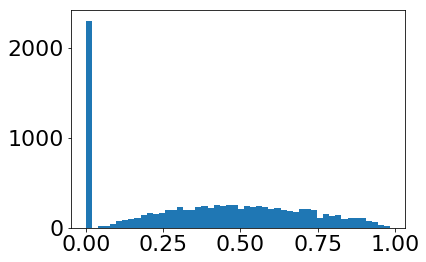

In [77]:
_ = plt.hist(blend_total_lsst, bins = 50)
blend_total_lsst.shape

In [67]:
image_total_1 = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Image_generation/blend_total_0.23.npy')
image_total_2 = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Image_generation/blend_total_0.53.npy')
image_total_3 = np.load('/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Image_generation/blend_total_0.82.npy')

In [68]:
image_total_3[1]

0.8280306458473206

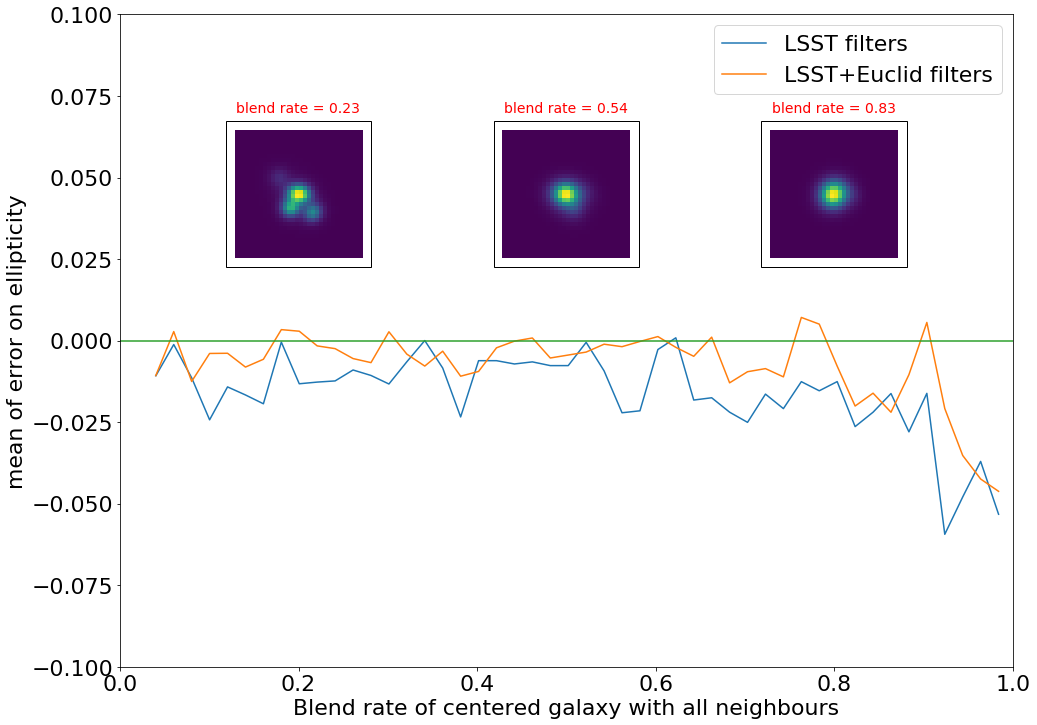

In [69]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,12))


mean_SNR_lsst, var_SNR_lsst = mean_var(blend_total_lsst,delta_e_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(blend_total_lsst_euclid,delta_e_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(blend_total_lsst_euclid), np.max(blend_total_lsst_euclid), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5


from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

imagebox = OffsetImage(image_total_1[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.2, 0.045))
axes.add_artist(ab)
axes.text(0.13, 0.07, 'blend rate = '+str(np.round(image_total_1[1], 2)), fontsize =14, color='r')

imagebox = OffsetImage(image_total_2[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.5, 0.045))
axes.add_artist(ab)
axes.text(0.43, 0.07, 'blend rate = '+str(np.round(image_total_2[1], 2)), fontsize =14, color='r')

imagebox = OffsetImage(image_total_3[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.8, 0.045))
axes.add_artist(ab)
axes.text(0.73, 0.07, 'blend rate = '+str(np.round(image_total_3[1], 2)), fontsize =14, color='r')

plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 1)
plt.ylim(-0.1, 0.1)

plt.xlabel('Blend rate of centered galaxy with all neighbours')
plt.ylabel('mean of error on ellipticity')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


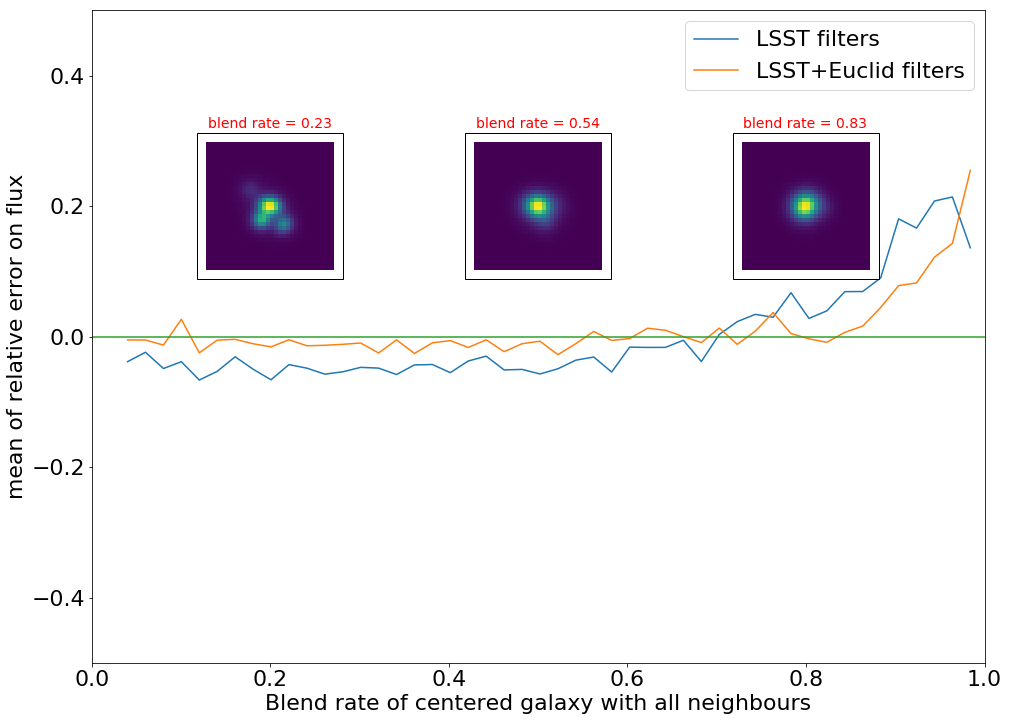

In [70]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,12))


mean_SNR_lsst, var_SNR_lsst = mean_var(blend_total_lsst,delta_flux_abs_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(blend_total_lsst_euclid,delta_flux_abs_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(blend_total_lsst_euclid), np.max(blend_total_lsst_euclid), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5


from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

imagebox = OffsetImage(image_total_1[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.2, 0.2))
axes.add_artist(ab)
axes.text(0.13, 0.32, 'blend rate = '+str(np.round(image_total_1[1], 2)), fontsize =14, color='r')

imagebox = OffsetImage(image_total_2[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.5, 0.2))
axes.add_artist(ab)
axes.text(0.43, 0.32, 'blend rate = '+str(np.round(image_total_2[1], 2)), fontsize =14, color='r')

imagebox = OffsetImage(image_total_3[0][6], zoom=4)
ab = AnnotationBbox(imagebox, (0.8, 0.2))
axes.add_artist(ab)
axes.text(0.73, 0.32, 'blend rate = '+str(np.round(image_total_3[1], 2)), fontsize =14, color='r')

plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 1)
plt.ylim(-0.5, 0.5)

plt.xlabel('Blend rate of centered galaxy with all neighbours')
plt.ylabel('mean of relative error on flux')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


Function of delta magnitude

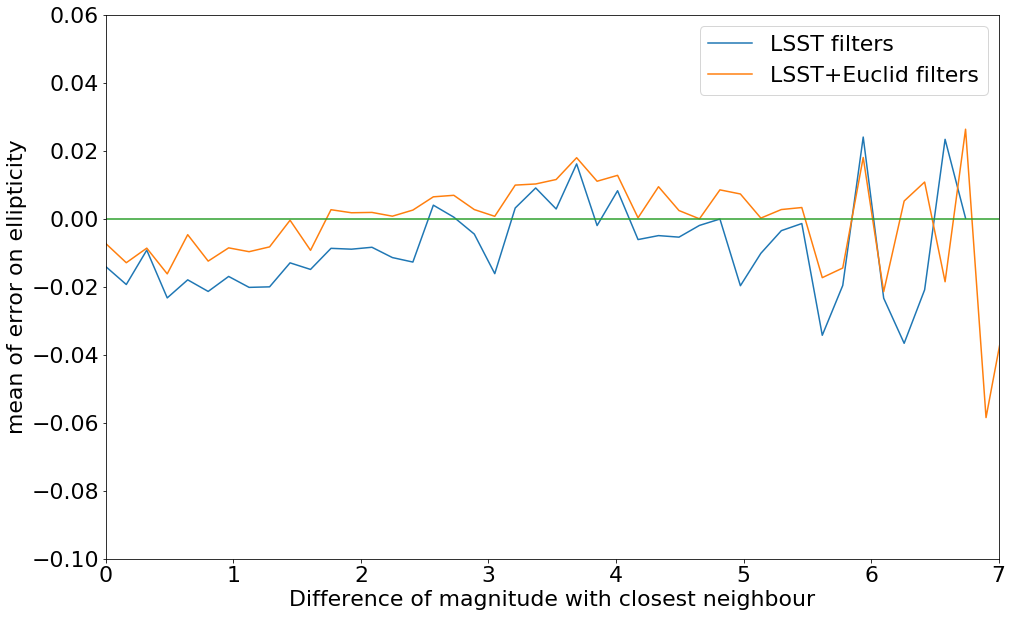

In [71]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,10))


mean_SNR_lsst, var_SNR_lsst = mean_var(delta_mag_lsst,delta_e_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(delta_mag_lsst_euclid,delta_e_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(delta_mag_lsst_euclid), np.max(delta_mag_lsst_euclid), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5



plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 7)#np.max(delta_mag_lsst))
plt.ylim(-0.10,0.06)

plt.xlabel('Difference of magnitude with closest neighbour')
plt.ylabel('mean of error on ellipticity')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


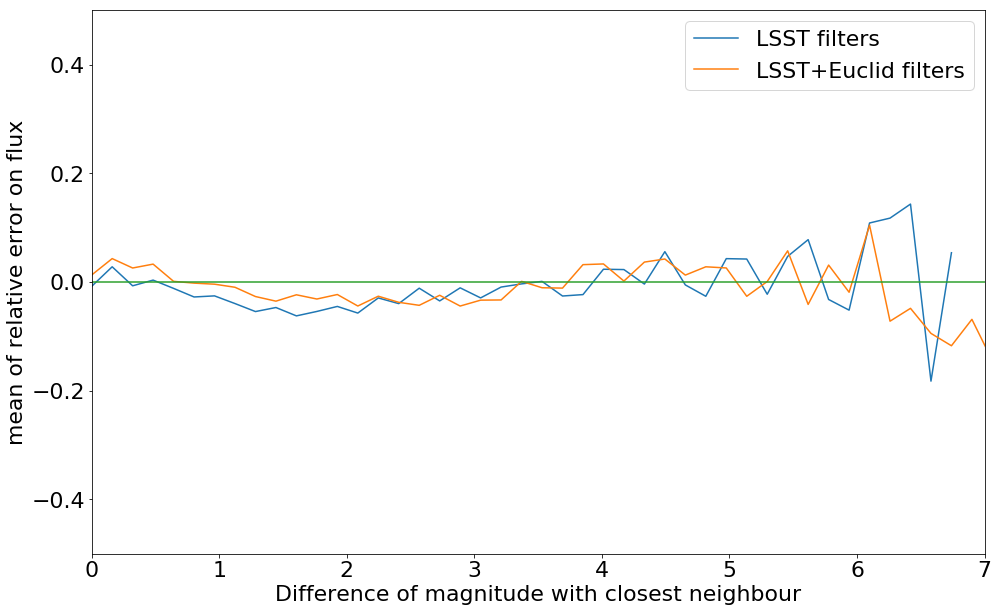

In [72]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,10))


mean_SNR_lsst, var_SNR_lsst = mean_var(delta_mag_lsst,delta_flux_abs_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(delta_mag_lsst_euclid,delta_flux_abs_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(delta_mag_lsst_euclid), np.max(delta_mag_lsst_euclid), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5



plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 7)#np.max(delta_mag_lsst))
plt.ylim(-0.5,0.5)

plt.xlabel('Difference of magnitude with closest neighbour')
plt.ylabel('mean of relative error on flux')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


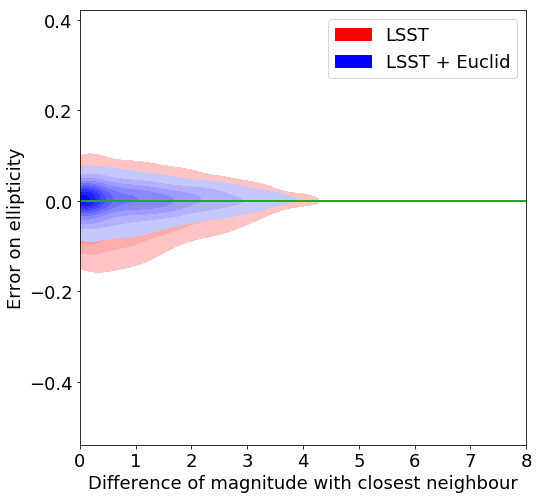

In [80]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(1, figsize=(8,8))

with sns.axes_style('white'):
            g = sns.kdeplot(delta_mag_lsst,delta_e_lsst, shade = True, color = 'r', shade_lowest=False, label = 'LSST')
            g = sns.kdeplot(delta_mag_lsst_euclid,delta_e_lsst_euclid, shade = True, color = 'b',shade_lowest=False, label = 'LSST + Euclid')
g.set_ylabel('Error on ellipticity')
g.set_xlabel('Difference of magnitude with closest neighbour')
g.plot(delta_mag_lsst, np.zeros((10000)))
g.set_xlim(0,8)
g.legend()

## N sampling

### N sampling for the same galaxy on few blended images

In [63]:
# define the number of samplings
N = 3
nb_of_samplings = 10

batch_size = 100

In [64]:
# Define the PSF used for measurement
PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
final_epsf_image = PSF.drawImage(scale=0.2)

0
0
1
2
3
4
5
6
7
8
9
1
0
1
2
3
4
5
6
7
8
9
2
0
1
2
3
4
5
6
7
8
9
0


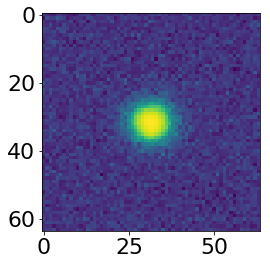

In [66]:
res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

res_out_lsst_euclid_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

flux_out_lsst = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
flux_out_lsst_euclid = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

gal = []
input_noiseless = []
input_noisy = []
output_deblender = []
output_deblender_lsst_euclid = []
blend_rate = []
nb_of_gal = []
err_count = 0

# Measurement of fluxes
mask = plot.createCircularMask(stamp_size,stamp_size,None,5)


for i in range (N):
    list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)
    gal.append(list_galsim_simple[0][0])
    
    input_noiseless.append(denorm(list_galsim_simple[1], bands_lsst_euclid, channel_last = True))
    
    plt.imshow(list_galsim_simple[0][0][:,:,2])#
    for k in range (len(list_galsim_simple[0])):
        list_galsim_simple[0][k] = gal[i]
    #try: 
    print(i)
    for j in range (nb_of_samplings):
        print(j)
        output_vae_list_lsst = deblender_lsst.predict(list_galsim_simple[0][:,:,:,4:], batch_size = batch_size)
        output_vae_list_lsst = denorm (output_vae_list_lsst, bands_lsst, channel_last = True)
        
        output_vae_list_lsst_euclid = deblender_lsst_euclid.predict(list_galsim_simple[0][:,:,:], batch_size = batch_size)
        output_vae_list_lsst_euclid = denorm (output_vae_list_lsst_euclid, bands_lsst_euclid, channel_last = True)
        
        if j == (nb_of_samplings-1) :  
            input_noisy.append(denorm(list_galsim_simple[0], bands_lsst_euclid, channel_last = True))
            output_deblender.append(output_vae_list_lsst)
            output_deblender_lsst_euclid.append(output_vae_list_lsst_euclid)
            blend_rate.append(list_galsim_simple[7][0])
            nb_of_gal.append(len(list_galsim_simple[5]))

        for t in range (batch_size):
            img_out_simple = galsim.Image(output_vae_list_lsst[t][:,:,2])
            res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
            res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
            res_out_lsst_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e   
            masked_img_in_simple = output_vae_list_lsst[t,:,:,2].copy()
            masked_img_in_simple[~mask] = 0  
            flux_out_lsst[i,j*batch_size+t] = np.sum(masked_img_in_simple)

            img_out_simple_euclid = galsim.Image(output_vae_list_lsst_euclid[t][:,:,6])
            res_out_lsst_euclid_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e1
            res_out_lsst_euclid_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e2
            res_out_lsst_euclid_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e   
            masked_img_in_simple = output_vae_list_lsst_euclid[t,:,:,6].copy()
            masked_img_in_simple[~mask] = 0  
            flux_out_lsst_euclid[i,j*batch_size+t] = np.sum(masked_img_in_simple)

    #except :
    #    err_count +=1
    #    print('erreur')
    #    pass
    #continue
            
print(err_count)

In [67]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')
res_in_e = np.empty([N], dtype='float32')
flux_in = np.empty([N], dtype='float32')

for k in range (N):
#    try: 
    img_in_simple = galsim.Image(input_noiseless[k][0][:,:,6])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    res_in_e[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e
    masked_img_in_simple = input_noiseless[k][0][:,:,6].copy()
    masked_img_in_simple[~mask] = 0  
    flux_in[k] = np.sum(masked_img_in_simple)

    print(res_in_e1[k], res_in_e2[k])

0.0024042267 -0.014175564
-0.09159544 -0.23867244
0.02603652 -0.035061926


[]

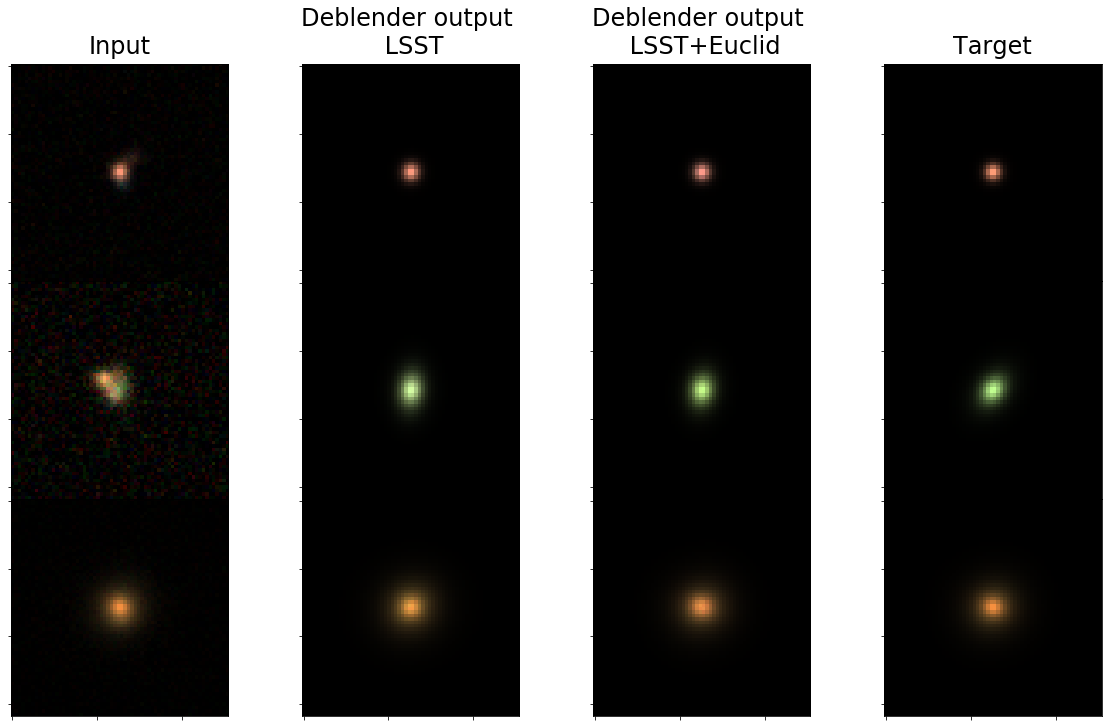

In [68]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
fig.subplots_adjust(hspace=0)

max_x = np.max((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
min_x = np.min((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
max_lim = np.max((np.abs(max_x), np.abs(min_x)))



####### Galaxy 1
ax = axes[0,0]
plot_rgb_lsst_euclid(input_noisy[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Input', pad = 10)

ax = axes[0,1]
plot_rgb_lsst(np.mean(output_deblender[0], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Deblender output \n LSST', pad = 10)

ax = axes[0,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[0], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Deblender output \n LSST+Euclid', pad = 10)

ax = axes[0,3]
plot_rgb_lsst_euclid(input_noiseless[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Target', pad = 10)


####### Galaxy 2
ax = axes[1,0]
plot_rgb_lsst_euclid(input_noisy[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
plot_rgb_lsst(np.mean(output_deblender[1], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[1], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,3]
plot_rgb_lsst_euclid(input_noiseless[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])


####### Galaxy 3
ax = axes[2,0]
plot_rgb_lsst_euclid(input_noisy[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
plot_rgb_lsst(np.mean(output_deblender[2], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[2], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,3]
plot_rgb_lsst_euclid(input_noiseless[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

In [69]:
blend_rate

[array([0.38177028, 0.7654134 , 0.11973627]),
 array([0.72421581, 0.21251348, 0.4324992 ]),
 array([0.54159147])]

0.3544558 0.3


Text(0.5, 0, 'total flux in - total flux out / \n total flux in')

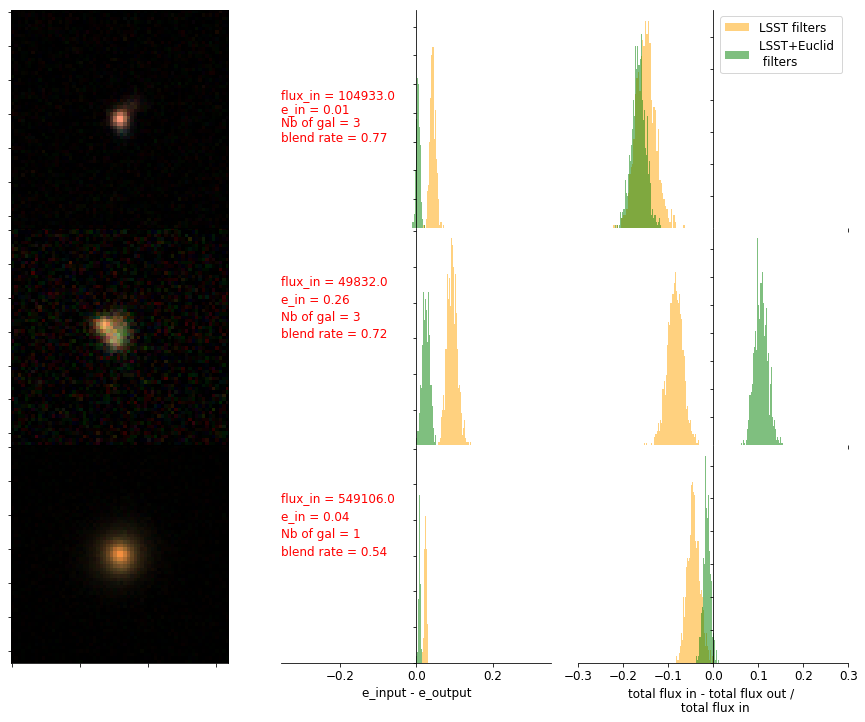

In [74]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(right=1, left=0,hspace=0,wspace=0.1)

max_x = np.max((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
min_x = np.min((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
max_lim = np.max((np.abs(max_x), np.abs(min_x)))

max_x = np.max(((flux_out_lsst[0]- flux_in[0])/flux_in[0], (flux_out_lsst[1]- flux_in[2])/flux_in[1], (flux_out_lsst[2]- flux_in[2])/flux_in[2]))
min_x = np.min(((flux_out_lsst[0]- flux_in[0])/flux_in[0], (flux_out_lsst[1]- flux_in[2])/flux_in[1], (flux_out_lsst[2]- flux_in[2])/flux_in[2]))
max_lim_flux = 0.3# np.max((np.abs(max_x), np.abs(min_x)))

print(max_lim, max_lim_flux)
####### Galaxy 1
ax = axes[0,0]
plot_rgb_lsst_euclid(input_noisy[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('Input', pad = 10)

ax = axes[0,1]
ax.hist(res_out_lsst_e[0]- res_in_e[0], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[0]- res_in_e[0], bins = 50, label ='LSST+Euclid \n filters' , alpha = 0.5, color = 'green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[0], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[0], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[0], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[0]), 0)), fontsize =12, color='r')
if len(blend_rate[0])!=0:
    ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[0]), 2)), fontsize =12, color='r')

ax.set_xlabel('e')
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('0utput measured \n ellipticity distribution', pad = 10)

ax = axes[0,2]
ax.hist((flux_out_lsst[0]- flux_in[0])/flux_in[0], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[0]- flux_in[0])/flux_in[0], bins = 50, label ='LSST+Euclid \n filters' , alpha = 0.5, color = 'green')
ax.set_xlabel('e')
ax.legend()
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('0utput measured \n ellipticity distribution', pad = 10)



####### Galaxy 2
ax = axes[1,0]
plot_rgb_lsst_euclid(input_noisy[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
ax.hist(res_out_lsst_e[1]- res_in_e[1], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[1]- res_in_e[1], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color ='green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[1], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[1], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[1], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[1]), 0)), fontsize =12, color='r')
if len(blend_rate[1])!=0:
    ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[1]), 2)), fontsize =12, color='r')

ax.set_xlabel('e')
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,2]
ax.hist((flux_out_lsst[1]- flux_in[1])/flux_in[1], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[1]- flux_in[1])/flux_in[1], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
ax.set_xlabel('e')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])


####### Galaxy 3
ax = axes[2,0]
plot_rgb_lsst_euclid(input_noisy[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
ax.hist(res_out_lsst_e[2]-res_in_e[2] , bins = 50, label ='LSST \n filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[2]- res_in_e[2], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[2], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[2], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[2], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[2]), 0)), fontsize =12, color='r')
if len(blend_rate[2])!=0:
       ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[2]), 2)), fontsize =12, color='r')

ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_yticklabels([])
ax.set_xlabel('e_input - e_output')


ax = axes[2,2]
ax.hist((flux_out_lsst[2]-flux_in[2])/flux_in[2] , bins = 50, label ='LSST \n filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[2]- flux_in[2])/flux_in[2], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_yticklabels([])
ax.set_xlabel('total flux in - total flux out / \n total flux in')


### N sampling for the same galaxy on the 10 000 and take the mean

In [16]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

N_sampling = 100
N = 1

ellipticities_n = np.zeros((N_sampling, batch_size, 2,2 ))
ellipticities = []
delta_r = []
e = []


for j in range(N):
    a = batch_gen.__getitem__(2)
    for k in range (N_sampling):
        output_vae = deblender.predict(a[0].reshape((100,64,64,6)), batch_size = batch_size)

        for i in range (batch_size):
            if (a[2][i]!=0):
                try: 
                        gal_image = galsim.Image(a[1][i].reshape((6,64,64))[2])
                        gal_image.scale = pix_scale

                        res = galsim.hsm.EstimateShear(gal_image, psf_image)
                        e_in = [res.corrected_e1, res.corrected_e2]
                        e_beta_in = [res.observed_shape.e, res.observed_shape.beta.rad]

                        gal_image = galsim.Image(output_vae[i].reshape((6,64,64))[2])
                        gal_image.scale = pix_scale

                        res = galsim.hsm.EstimateShear(gal_image, psf_image)
                        e_out = [res.corrected_e1, res.corrected_e2]
                        e_beta_out = [res.observed_shape.e, res.observed_shape.beta.rad]

                        ellipticities_n[k,i] = [e_in, e_out]
                        e.append([e_beta_in, e_beta_out])
                except :
                    print('error for galaxy '+str(j*100+i)+' sample '+str(k))
                    pass
                continue
                delta_r.append(a[2][i])
    print(np.array(ellipticities_n).shape)
    
    ellipticities.append(np.mean(np.array(ellipticities_n), axis = 0))
    print(np.array(ellipticities).shape)
        
        
ellipticities_r_band = np.array(ellipticities).reshape((100,2,2))
delta_r_list = np.array(delta_r)
e_beta = np.array(e)

(100, 100, 2, 2)
(1, 100, 2, 2)


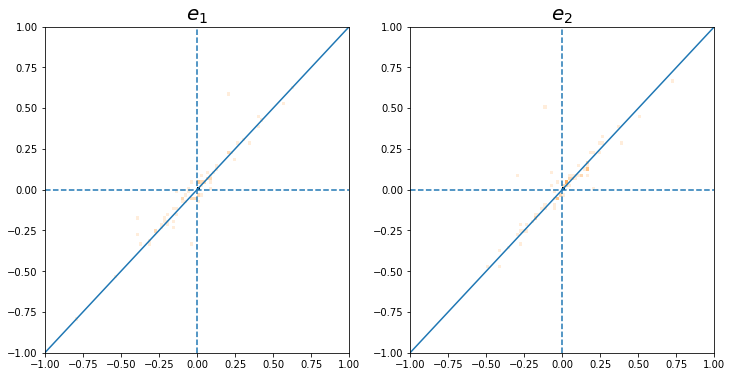

In [18]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'

In [24]:
delta_e1 = ellipticities_r_band[:,0,0]-ellipticities_r_band[:,1,0]
delta_e2 = ellipticities_r_band[:,0,1]-ellipticities_r_band[:,1,1]

ValueError: The dimension of bins must be equal to the dimension of the  sample x.

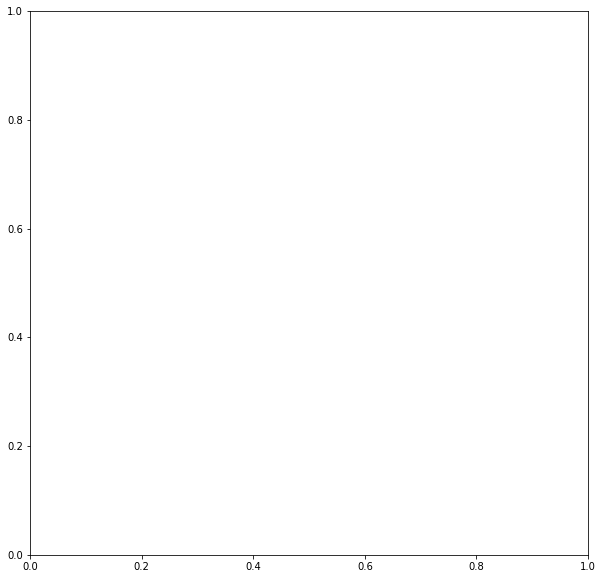

In [26]:
fig = plt.figure(figsize = (10,10))
_ = plt.hist2d(delta_r, delta_e1, bins=np.linspace(-1,4,10), cmap=mpl.cm.gist_heat_r)
plt.xlim(-0.1,3.5)
plt.ylim(-1,1)
plt.plot((-1, 4),(0,0))

In [ ]:
# define the number of samplings
N = 3
nb_of_samplings = 10

batch_size = 100

In [ ]:
# Define the PSF used for measurement
PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
final_epsf_image = PSF.drawImage(scale=0.2)

In [ ]:
res_out_r_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_r_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')


gal = []
err_count = 0

for i in range (N):
    list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)
    gal.append(list_galsim_simple[0][0])
    
    plt.imshow(list_galsim_simple[0][0].reshape((10,64,64))[6])#
    for k in range (len(list_galsim_simple[0])):
        list_galsim_simple[0][k] = gal[i]
    try: 
        print(i)
        for j in range (nb_of_samplings):
            print(j)
            output_vae_list_r = vae_lsst_r_band_conv.predict(list_galsim_simple[0].reshape((batch_size,10,64,64))[:,6], batch_size = batch_size)
            output_vae_list_r = output_vae_list_r.reshape((batch_size,64,64))

            output_vae_list_lsst = vae_lsst_conv.predict(list_galsim_simple[0].reshape((batch_size,10,64,64))[:,4:].reshape((batch_size,64,64,6)), batch_size = batch_size)
            output_vae_list_lsst = output_vae_list_lsst.reshape((batch_size,6,64,64))

            output_vae_list_lsst_euclid = vae_lsst_euclid_conv.predict(list_galsim_simple[0], batch_size = batch_size)
            output_vae_list_lsst_euclid = output_vae_list_lsst_euclid.reshape((batch_size,10,64,64))

            for t in range (batch_size):
                img_out_simple = galsim.Image(output_vae_list_r[t])
                res_out_r_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_r_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2

                img_out_simple = galsim.Image(output_vae_list_lsst[t,2])
                res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2

                img_out_simple = galsim.Image(output_vae_list_lsst_euclid[t,6])
                res_out_lsst_euclid_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_lsst_euclid_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
#print(res_out[i,j*batch_size+t])

            
            
    except :
        err_count +=1
        print('erreur')
        pass
    continue
            
print(err_count)

In [ ]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')

for k in range (N):
#    try: 
    img_in_simple = galsim.Image(gal[k].reshape((10,64,64))[6])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    print(res_in_e1[k], res_in_e2[k])

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(2,3, figsize=(25,14))

ax = axes[0,0]
_ = ax.hist(res_out_r_e1[0],  bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[0], bins = 50,label ='LSST filters' ,  alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[0], bins = 50,label = 'LSST+Euclid \n filters' ,  alpha = 0.5)
variance = np.var(res_out_r_e1[0])
sigma = np.sqrt(variance)
x = np.linspace(min(res_out_r_e1[0]), max(res_out_r_e1[0]), 100)
#ax.plot(x, mlab.normpdf(x, mean, sigma))


ax.axvline(res_in_e1[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,1]
_ = ax.hist(res_out_r_e1[1] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[1] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[1] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e1[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,2]
_ = ax.hist(res_out_r_e1[2] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[2] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[2] , bins = 50,label = 'LSST+Euclid \n filters' ,  alpha = 0.5)

ax.axvline(res_in_e1[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e1')
ax.legend()

ax = axes[1,0]
_ = ax.hist(res_out_r_e2[0] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[0] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[0] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,1]
_ = ax.hist(res_out_r_e2[1] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[1] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[1] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,2]
_ = ax.hist(res_out_r_e2[2] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[2] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[2] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e2')
ax.legend()

plt.tight_layout()

# Compare deblender LSST vs LSST+Euclid

In [41]:
def compare_deblender(deb1, deb2,nb_1, nb_2, input_deb_1, input_deb_2, expected):
    ######
    # deb1, deb2 : the 2 deblenders which are being compared
    # nb_1, nb_2 : number of bands in the images processed respectively by deb1 and deb2
    # input_deb_1, input_deb_2 : the noisy blended images to process respectively for deb1 and deb2
    # expected: the noiseless centered galaxy images which are the targerts for the deblender 1
    ######
    # List of noisy blended images
    list_blended_1 = input_deb_1.reshape(len(input_deb_1),64,64,nb_1)
    list_blended_2 = input_deb_2.reshape(len(input_deb_2),64,64,nb_2)
    print(list_blended_1.shape)
    # List of noiseless centered galaxy
    list_simple = expected
    
    # Use deblenders on list of blended images
    list_output_1 = deb1.predict(list_blended_1, batch_size= 100)
    list_output_2 = deb2.predict(list_blended_2, batch_size= 100)
    
    # Reshape the lists so that it can be used for measurement
    list_output_1 = list_output_1.reshape(len(input_deb_1),nb_1,64,64)
    list_output_2 = list_output_2.reshape(len(input_deb_2),nb_2,64,64)
    print(list_output_1.shape)
    list_simple = list_simple.reshape(len(expected),nb_1,64,64)

    # Create empty lists for the futur measurements
    g_in = np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    g1_in= np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    g2_in= np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    
    g_out_1 = np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')
    g1_out_1= np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')
    g2_out_1= np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')

    g_out_2 = np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')
    g1_out_2= np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')
    g2_out_2= np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')

    err_count = 0
    for i in range (100):#len(input_deb_1)):
#        try :
        #print('image : '+str(i))
        # Add a PSF to be able to do an estimation of the shear
        PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
        final_epsf_image = PSF.drawImage(scale=0.2)

        # Define the images
        img_in = galsim.Image(list_simple[i,nb_1-4,16:48,16:48])
        #print(list_blended_1.shape)
        img_out_1 = galsim.Image(list_output_1[i,nb_1-4,16:48,16:48])
        img_out_2 = galsim.Image(list_output_2[i,nb_2-4,16:48,16:48])
        #print(list_output_1[i,nb_1-4,16:48,16:48].shape, str(nb_1-4))
        #print(list_output_2[i,nb_2-4,16:48,16:48].shape, str(nb_2-4))
        #plt.imshow(list_output_1[i,nb_1-4])
        # Measurements 
        ## for the input image
        g_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g
        #print(g_in[i])
        g1_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g1
        #print(g1_in[i])
        g2_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g2
        #print(g2_in[i])
        
        ## for the output image for the deblender deb1
        g_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g
        #print(g_out_1[i])
        g1_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g1
        #print(g1_out_1[i])
        g2_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g2
        #print(g2_out_1[i])
        ## for the output image for the deblender deb2
        g_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g
        #print(g_out_2[i])
        g1_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g1
        #print(g1_out_2[i])
        g2_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g2
        #print(g2_out_2[i])
#        except :
#            err_count +=1
#            print('erreur')
#            pass
#        continue
#    print(err_count)
    
    return g_in, g1_in, g2_in, g_out_1, g1_out_1, g2_out_1, g_out_2, g1_out_2, g2_out_2

In [42]:
g_in, g1_in, g2_in, g_out_1, g1_out_1, g2_out_1, g_out_2, g1_out_2, g2_out_2 = compare_deblender(deblender_lsst, deblender_lsst_euclid,6,10,input_deblender_lsst, input_deblender_lsst_euclid, input_deblender_no_noise_lsst)

(10000, 64, 64, 6)
(10000, 6, 64, 64)
image : 0
0.2082479
0.19913106
-0.060942654
0.036790792
0.034009717
-0.014032165
0.16499282
0.15605693
-0.0535618
image : 1
0.16798127
-0.026451362
0.1658856
0.15658477
-0.03602771
0.15238371
0.17420697
-0.019408643
0.17312242
image : 2
0.015851352
-0.0019065625
-0.015736276
0.08868295
-0.021780383
-0.085966736
0.02348353
-0.021882499
-0.008522464
image : 3
0.021669954
0.014525538
0.016080908
0.020390408
0.020253738
-0.002356865
0.03144208
0.021906106
0.022554975
image : 4
0.20160483
-0.0011992565
0.20160127
0.20832688
0.00688239
0.20821317
0.18581249
0.011259531
0.18547103
image : 5
0.23158796
-0.104689494
0.20657468
0.23533344
-0.12658247
0.19839028
0.2287074
-0.10791111
0.20164888
image : 6
0.11998794
-0.117808565
-0.022765057
0.07408505
-0.010791827
-0.07329482
0.10861742
-0.10680394
-0.01976517
image : 7
0.049526952
-0.0055145873
-0.049218982
0.04815506
0.0016616306
-0.04812638
0.06094573
-0.003158866
-0.06086381
image : 8
0.04619206
-0.017668

-0.12442082
0.10392915
0.04133713
-0.095354654
image : 74
0.11875908
0.112435594
0.03823554
0.12378496
0.122179255
0.01987324
0.08360412
0.076007724
0.034820616
image : 75
0.20552595
-0.003458937
-0.20549685
0.20924947
-0.036455277
-0.20604938
0.18458277
0.0022645297
-0.18456888
image : 76
0.13287856
-0.12798539
0.03572745
0.13762611
-0.13466565
0.02839205
0.14154579
-0.13268964
0.049281526
image : 77
0.12189686
0.05458897
0.10899032
0.04391239
0.040948823
0.015858488
0.12846608
0.053195484
0.11693492
image : 78
0.07118125
0.06414389
0.03085987
0.05739784
0.054537885
0.017892204
0.057015285
0.044195596
0.036020715
image : 79
0.3680707
0.28004238
0.23885626
0.36813596
0.26644644
0.25402832
0.36800182
0.25942957
0.2610012
image : 80
0.1587331
-0.07762931
-0.13845536
0.19166158
-0.09155821
-0.16837832
0.16123722
-0.09631994
-0.1293055
image : 81
0.05116644
-0.035789974
-0.036566135
0.052614756
0.0011119178
-0.052603006
0.037910182
0.0035725504
-0.03774147
image : 82
0.12260909
-0.06430983

In [43]:
# Calculate the differences from output measurement compared to input
## LSST
delta_g_lsst = g_in - g_out_1
delta_g1_lsst = g1_in- g1_out_1
delta_g2_lsst = g2_in-g2_out_1

## LSST + Euclid
delta_g_lsst_euclid = g_in - g_out_2
delta_g1_lsst_euclid = g1_in- g1_out_2
delta_g2_lsst_euclid = g2_in-g2_out_2


The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


ValueError: weights should have the same shape as a.

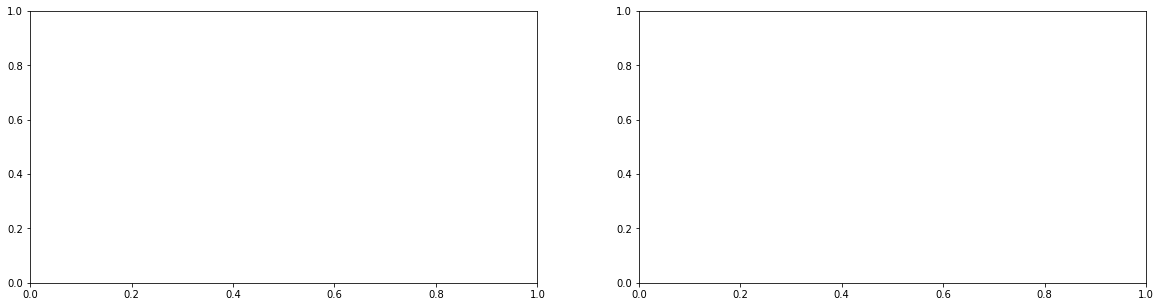

In [63]:
# Plot of the LSST and LSST+Euclid results comparison

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

bins = np.linspace(0, 50,100)
mid = (bins[1:]+bins[:-1])*0.5

mean_delta_g, var_delta_g = mean_var(delta_r,delta_g_lsst_euclid,bins)
mean_delta_g1, var_delta_g1 = mean_var(delta_r,delta_g1_lsst_euclid,bins)
mean_delta_g2, var_delta_g2 = mean_var(delta_r,delta_g2_lsst_euclid,bins)

mean_delta_g_lsst, var_delta_g_lsst = mean_var(delta_r,delta_g_lsst,bins)
mean_delta_g1_lsst, var_delta_g1_lsst = mean_var(delta_r,delta_g1_lsst,bins)
mean_delta_g2_lsst, var_delta_g2_lsst = mean_var(delta_r,delta_g2_lsst,bins)



ax = axes[0]
ax.plot(mid, mean_delta_g1, label = 'LSST-EUCLID')
ax.fill_between(mid, mean_delta_g1 - 10*var_delta_g1**0.5, mean_delta_g1 + 10*var_delta_g1**0.5, alpha=0.5)
ax.plot(mid, mean_delta_g1_lsst, label = 'LSST')
ax.fill_between(mid, mean_delta_g1_lsst - 10*var_delta_g1_lsst**0.5, mean_delta_g1_lsst + 10*var_delta_g1_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g1', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.plot(mid,mid*0)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
ax.set_ylim(-0.5,0.5)

ax = axes[1]
ax.plot(mid, mean_delta_g2, label = 'LSST-EUCLID')
ax.fill_between(mid, mean_delta_g2 - 10*var_delta_g2**0.5, mean_delta_g2 + 10*var_delta_g2**0.5, alpha=0.5)
ax.plot(mid, mean_delta_g2_lsst, label = 'LSST')
ax.fill_between(mid, mean_delta_g2_lsst - 10*var_delta_g2_lsst**0.5, mean_delta_g2_lsst + 10*var_delta_g2_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g2', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.plot(mid,mid*0)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
#ax.set_ylim(-0.5,0.5)

### Only the LSST results